# Árboles

Boletín 3: árboles
Para la realización de las prácticas de esta segunda parte de la materia se utilizará scikit-learn, una
librería de aprendizaje estadístico en Python, a través de Jupyter Notebooks. La ejecución se realizará
en el CESGA siguiendo los pasos indicados en el archivo CESGA.pdf.


### Instrucciones para la experimentación en TODOS los boletines de prácticas

En los diferentes ejercicios que se realizarán durante el curso, existen una serie de operaciones con una componente aleatoria: la división en entrenamiento y test, el aprendizaje de un modelo o incluso, en
algunos casos, el test del modelo. Como norma general de experimentación es interesante asegurar la repetibilidad de los experimentos, eliminando la aleatoriedad, puesto que nos permite depurar errores,
comparar modelos, etc. Además, para la evaluación de los boletines también es imprescindible eliminar esa aleatoriedad.

Para ello vamos a fijar la semilla del generador de números aleatorios, de tal manera que su secuencia sea siempre la misma. La semilla se establece mediante el comando np.random.seed(SEED_VALUE), y
en este boletín utilizaremos un SEED_VALUE=1. Será necesario utilizar este comando inmediatamente antes de cualquier operación con un componente aleatorio. Esto incluye: train_test_split(), fit(),
predict(), etc. En aquellas funciones que lo admitan, sustituiremos el comando np.random.seed(SEED_VALUE) por el argumento random_state=SEED_VALUE.

In [1]:
!python --version

Python 3.11.5


In [2]:
!python3 --version

Python 3.11.5


## Importamos las librerías a utilizar

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
import matplotlib

import os
import itertools

In [4]:
%matplotlib inline
matplotlib.style.use('ggplot')
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  # Para evitar warnings en algunas gráficas
import warnings

# Filtrar y ocultar todos los warnings
warnings.filterwarnings('ignore')

## Definimos variables globales

In [5]:
DATASET_NAME = './data/Exercice.data'
DATASET_DELIMITER = ','
SEED_VALUE = 1  # NO CAMBIES ESTA SEMILLA, así todos tendremos los mismos resultados

# Ejercicio 1

Dado el siguiente conjunto de datos de clasificación con 6 observaciones, 3 variables de entrada y
una variable de salida:



## Leemos el fichero de datos

In [8]:

if os.path.exists(DATASET_NAME):
    dataset = pd.read_csv(DATASET_NAME, 
                          delimiter=DATASET_DELIMITER,
                          skiprows=0,
                          header=None,
                          names = ["X1", "X2", "X3", "Y"])
else:
    dataset = d.DataFrame(np.array(
    [[ 1,  4,  3, -1,  1],
       [ 2, -3, -1, -1,  0],
       [ 3,  3, -2,  0,  0],
       [ 4,  1,  4,  0,  1],
       [ 5, -2,  3,  1,  0],
       [ 6, -3,  5,  5,  0]]), columns=['X1', 'X2', 'X3', 'Y'])
dataset

,X1,X2,X3,Y
1,4,3,-1,1
2,-3,-1,-1,0
3,3,-2,0,0
4,1,4,0,1
5,-2,3,1,0
6,-3,5,5,0


El fichero contiene 3 variables y 17 observaciones distintas. Las variables predictoras son `X0` y `X1`, y la variable dependiente sería `Y`. Estamos ante un problema de clasificación binario (dada la naturaleza booleana de `Y`, existen 2 clases).

## Visualizamos los datos

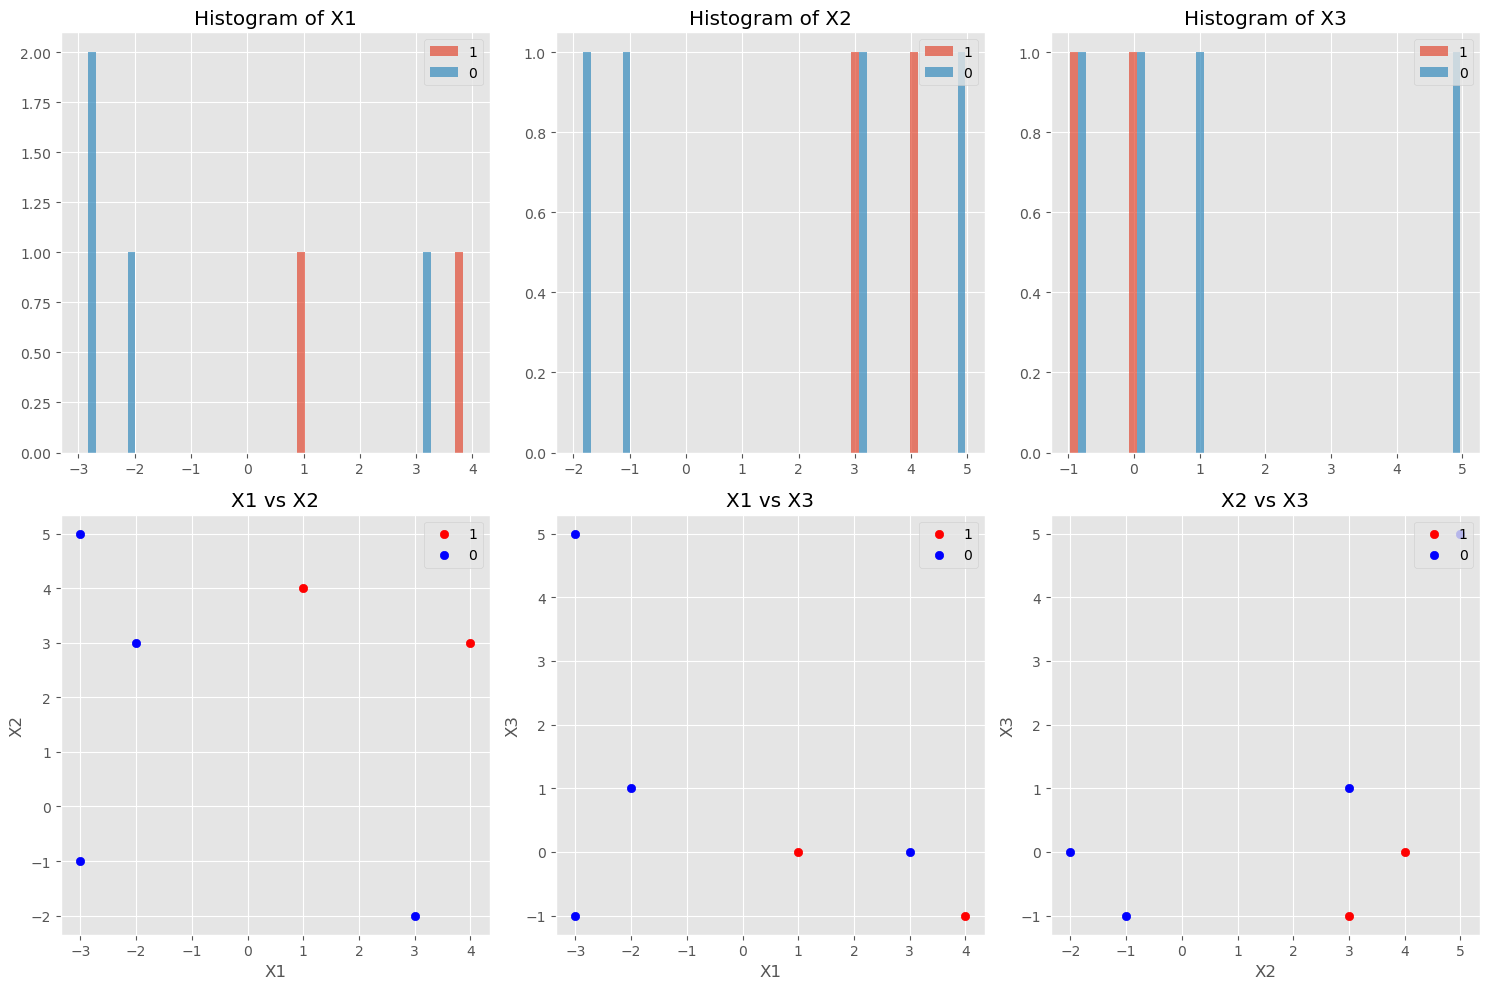

In [9]:

columns = dataset.columns[:-1]  # Exclude the 'Y' column

# Create a 2x3 subplot grid for both histogram and scatter plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Visualize histograms for the first three columns
for i, column in enumerate(columns[:3]):
    axs[0, i].hist([dataset[dataset['Y'] == 1][column], dataset[dataset['Y'] == 0][column]], label=['1', '0'], bins=20, alpha=0.7)
    axs[0, i].set_title("Histogram of {}".format(column))
    axs[0, i].legend(loc='upper right')

# Create combinations of variables for scatter plot comparison
combinations = list(itertools.combinations(columns, 2))

# Visualize scatter plots for the remaining combinations
for j, (var1, var2) in enumerate(combinations):
    k = j + 1  # Start from the second row
    scatter1 = axs[1, j].scatter(dataset[dataset['Y'] == 1][var1], dataset[dataset['Y'] == 1][var2], c='red', label='1')
    scatter0 = axs[1, j].scatter(dataset[dataset['Y'] == 0][var1], dataset[dataset['Y'] == 0][var2], c='blue', label='0')
    axs[1, j].set_title("{} vs {}".format(var1, var2))
    axs[1, j].set_xlabel(var1)
    axs[1, j].set_ylabel(var2)
    axs[1, j].legend(handles=[scatter1, scatter0], loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

Suponiendo que se quiere hacer la predicción de la variable de salida para X1=0, X2=0, X3=0
mediante KNN.

In [8]:
# definimos nuestro punto para la prediccion
point=np.array([0,0,0])

Construye el árbol de clasificación (sin podar) mediante CART y utilizando como criterio la entropía.
La condición de parada debe ser que los nodos hoja sean puros (todos los ejemplos son de la misma
clase). 

En cada nodo del árbol se debe indicar:
- La variable y su valor umbral.
- La entropía correspondiente.
- En los nodos hoja, la clase del nodo y los ejemplos que pertenecen al mismo.

**Nota:** este ejercicio debe hacerse sin utilizar ninguna función de scikit-learn.

ecuación de entropia:

$$ H(X) = -\sum_{i=1}^{n} P(x_i) \log_2 P(x_i) $$

- H(X) representa la entropía del nodo.

- P(xi​) es la probabilidad de cada clase ii, y la sumatoria se realiza sobre todas las clases nn en el conjunto de datos.

Para saber cual es la mejor división se usa esta ecuación

$$ H(X) = entropia_{right} \times numitems_{right} + numitems_{left} \times entropia_{left} $$

- H(X) representa la entropía del de la división- H(X) representa la entropía del árbol.

In [22]:
from collections import Counter
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter


class Nodo:
    def __init__(self,values,father=None,index=0,show=False):
        """
        values: value of variable ( array )
        labels: lables class in order ( array )
        self itemem
        """
        
        self.values=values
        self.labels=values[-1]
        self.show=show
        if self.show:
            print('valores_iniciales',self.values)
        self.cant_values=len(self.labels)
        self.class_names=np.unique(self.labels)
        self.values_per_variable=[]
        self.entropia=self.get_entropia()
        self.index=index
        self.depth= 0 if father is None else father.depth + 1
        self.father=father 
        self.left=None
        self.rigth=None
        self.umbral=None
        self.id = f'Node {self.depth}-{self.index}'
        self.variante=0
        
    def procesar_entradas(self,indice=0):
        
   
        xi=self.values[indice].T
        
        subsets_xi = [self.values.T[xi == value] for value in np.unique(xi)]
        #print(xi)
        xi=[i.T[indice] for i in subsets_xi]
        self.values_per_variable.append(np.array([item for array in subsets_xi for item in array.tolist()]))
        xi=[item for array in xi for item in array.tolist()]
        #print("a",xi,subsets_xi)
        #print("a", self.values_per_variable)
        #self.values_per_variable.append(xi)
        y1=[i.T[-1] for i in subsets_xi]
        y1=[item for array in y1 for item in array.tolist()]
        #print("label_nodo",y1,subsets_xi)
        return y1
    
    def get_entropia(self):
        entropia_min=[]
        
        for i,_ in enumerate(self.values[:-1]):
            labels_sorted=self.procesar_entradas(i)
            #print(labels_sorted)
            entropia=-np.sum(np.array(list(map(lambda class_name: 
                                               self.entropia_val(class_name,labels_sorted), self.class_names))))
            #print(entropia)
            entropia_min.append(entropia)
              
        return np.array(entropia_min)
    
    def entropia_val(self,class_name,labels_sorted):
        #print('label',labels_sorted)
        p=len(np.where(labels_sorted == class_name)[0])/ self.cant_values
        return p * math.log(p, 2) if p > 0 else 0  # Evita el logaritmo de cero
    
    def get_umbral(self,split_entropias,variante):
        
        values=self.values_per_variable[variante].T[variante]
        if self.show:
            print(values)
        return (values[split_entropias-1]+values[split_entropias])/2
    
    def generate_new_nodo_only_one(self,valor):
        
        return np.array([[valor[0]],[valor[1]]])
    
    def get_best_split(self):
        
        entropias_all_split=np.matrix([self.get_entropia_split(i+1) for i in range(self.cant_values-1)])
        split_entropias=np.argmin(entropias_all_split)
        split_entropias,variante=np.unravel_index(split_entropias, entropias_all_split.shape)#np.argmin(entropias_all_split)
        if self.show:
            print(entropias_all_split,split_entropias,variante)
        if self.cant_values-split_entropias>1 and len(entropias_all_split)>1:
           
            split_entropias+=1
            
        #print(entropias_all_split,split_entropias,len(entropias_all_split)>1)
        if len(entropias_all_split)>1:
            if self.show:
                print("nuevo_nodo",self.values_per_variable[variante][:split_entropias].T)
            self.rigth=Nodo(self.values_per_variable[variante][:split_entropias].T
                            ,self,0,show=False)
            self.left=Nodo(self.values_per_variable[variante][split_entropias:].T
                           ,self,1,show=False)
            self.values=self.values_per_variable[variante].T
            self.labels=self.values[-1]
            self.umbral=self.get_umbral(split_entropias,variante)

        elif self.cant_values>1:
            if self.show:
                print("nuevo_nodo_solo",np.array(self.values_per_variable[variante][0]))
            self.rigth=Nodo(self.generate_new_nodo_only_one(self.values_per_variable[variante][0])
                             ,self,0,show=False)
            self.left=Nodo(self.generate_new_nodo_only_one(self.values_per_variable[variante][1])
                           ,self,1,show=False)
            self.umbral=self.get_umbral(1,variante)
        
        self.variante=variante
        return self.rigth,self.left
    
    def get_entropia_split(self,i):
        entropia=[]
        for variante,_ in enumerate(self.values_per_variable):
            nodo_probe_1=Nodo(self.values_per_variable[variante][:i].T)
            nodo_probe_2=Nodo(self.values_per_variable[variante][i:].T)
            entropia.append(nodo_probe_1.entropia[variante]* self.cant_values +
                            nodo_probe_2.cant_values*nodo_probe_2.entropia[variante])
        return entropia
    
    def get_entropia_value(self):
        if self.show:
            print('self.entropia',self.entropia)
        return np.min(self.entropia)
    
    def __str__(self):
        return f"{self.id },{self.cant_values},{self.labels}"#f"{self.umbral},{self.rigth},{self.left}"

    def draw(self, G, pos=None, labels=None, parent_name=None):
        # If this is the first call, create new structures
        if pos is None:
            pos = {}
        if labels is None:
            labels = {}
        if self.show:
            print(self.values)   
            print(self.labels)
        # Create a unique identifier for the current node
        node_id = f'Node {self.depth}-{self.index}'
        labels[node_id] = (f'umbral para X{self.variante+1}<= {self.umbral}\nsamples={self.cant_values}\nentropy={self.get_entropia_value():.3f}'
        f'\nvalue={self.values.T}\nlabel={self.labels}\nclass={Counter(self.labels).most_common(1)[0][0]}')
        
        # Determine the position of the current node based on its depth and index
        pos[node_id] = (self.index, -self.depth)
        #print(pos)
        # Add the current node to the graph
        G.add_node(node_id)

        # If this node has a parent, add an edge from the parent to this node
        if parent_name is not None:
            G.add_edge(parent_name, node_id)
        
        # Recursively draw the children
        if self.left is not None:
           
            self.left.draw(G, pos, labels, node_id)
            
        if self.rigth is not None:
            self.rigth.draw(G, pos, labels, node_id)

        return G, pos, labels
    
class Tree_class:
    def __init__(self,values,num_nodos=-1,pure=True):
        self.root=Nodo(values)
        self.next=[self.root]
        cont=0
        while True: 
            element=self.next.pop()
            #print(element)
            if element.get_entropia_value()>0:
                right,left=element.get_best_split()
                #print(right,left)
                if left is not None:
                    self.next.append(right)
                    self.next.append(left)
            #print(self.next)
            cont=+1
            if len(self.next)<=0 or cont==2:
                break
            
    def draw_tree(self):
        G = nx.DiGraph()
        # Start the recursive drawing from the root
        G, pos, labels = self.root.draw(G)
        
        # Draw the graph
        plt.figure(figsize=(12, 8))
        #nx.draw(G, pos, labels=labels, with_labels=True, arrows=False)
        # Draw the nodes
        nx.draw_networkx_nodes(G, pos, node_size=4500, node_color="skyblue")

        # Draw the edges
        nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20)

        # Draw the labels inside rectangles
        for node, label in labels.items():
            x, y = pos[node]
            plt.text(x, y, label, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black'))

        # Remove the axis
        plt.axis('off')
        
        plt.show()

        


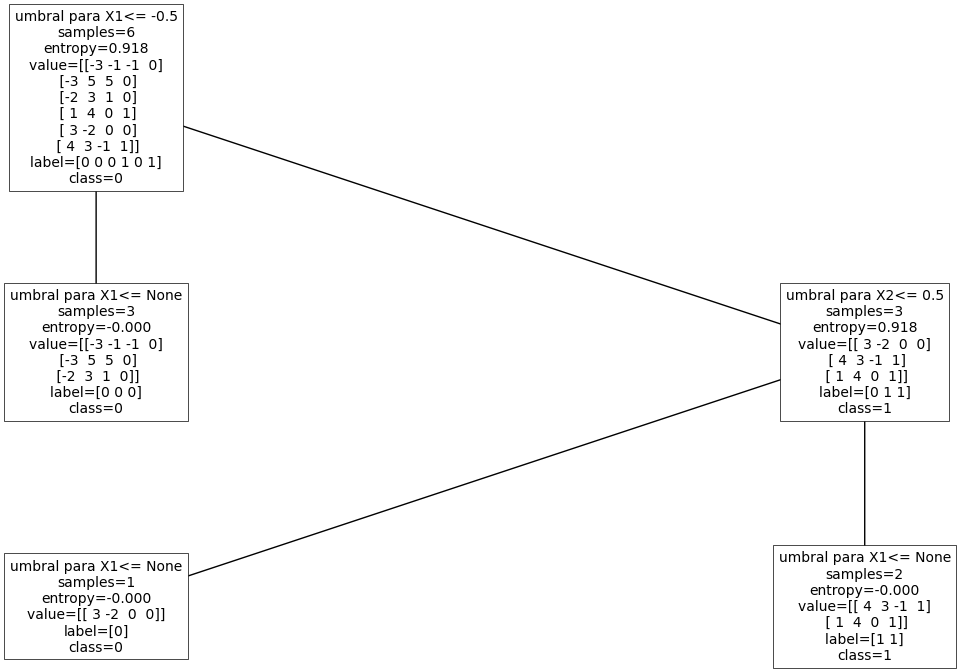

In [23]:
datos=dataset.to_numpy()
#print(datos)
x11=datos.T[0]
#print(x11)
x1=datos.T[:]
subsets_x1 = [x1.T[x11 == value] for value in np.unique(x11)]
#print(subsets_x1)
xi=[i.T[0] for i in subsets_x1]
#print(xi)
#print(x1.T[:2].T,x1,x1[2])
arbol=Tree_class(x1)
arbol.draw_tree()


### Comparamos el resultado con scikit-learn

In [24]:
# Separar las características y la variable objetivo
X = dataset[['X1', 'X2', 'X3']]
y = dataset['Y']

clf = DecisionTreeClassifier()
clf.fit(X, y)


DecisionTreeClassifier()

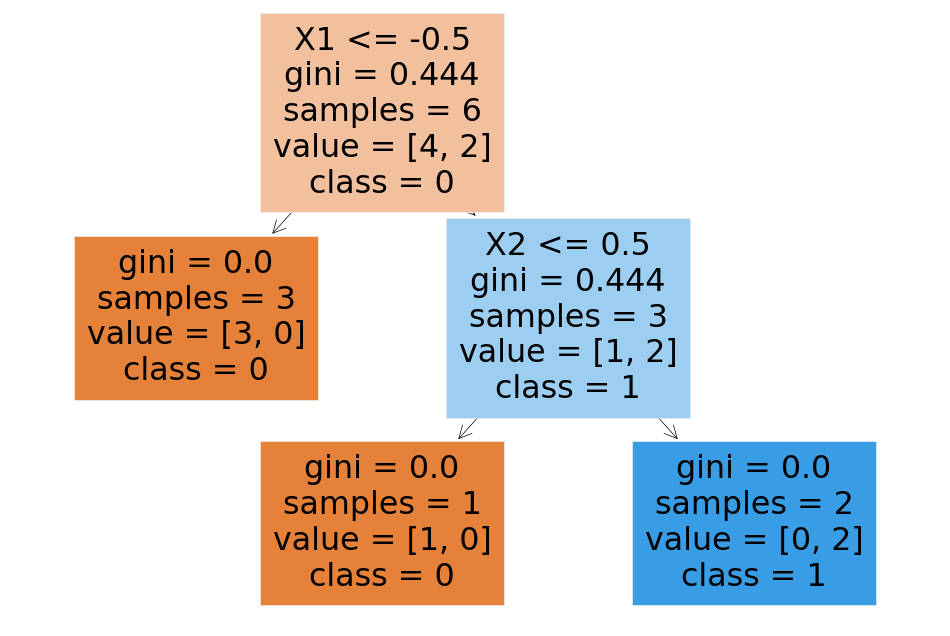

In [25]:
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=['X1', 'X2', 'X3'], class_names=['0', '1'])
plt.show()

Como se pude obsevar el resultado es similar por lo que podemos saber que esta haceindo correctamente la división

# Ejercicio 2

Dado el problema de clasificación [Blood Transfusion Service Center](https://archive.ics.uci.edu/dataset/176/blood+transfusion+service+center):


**a)Analiza las características del conjunto de datos: número y tipo de variables de entrada y
salida, número de instancias, número de clases y distribución de las mismas, correlación
entre las variables, valores perdidos, etc.** 

## Leemos el fichero de datos

In [26]:
DATASET_BLOOD='./data/blood+transfusion+service+center/bloodTransfusion.data'
# Leer el archivo de datos y obtener la primera fila como nombres de columnas
data = pd.read_csv(DATASET_BLOOD)
NAME_BLOOD = data.columns.tolist()

NAME_BLOOD=["Reciente","Frecuencia","Cantidad_Sangre","Tiempo","Donacion_marzo"]
if os.path.exists(DATASET_BLOOD):
    dataset = pd.read_csv(DATASET_BLOOD, 
                          delimiter=DATASET_DELIMITER,
                          skiprows=1,
                          header=None,
                          names = NAME_BLOOD)
else:
    dataset = d.DataFrame(np.array(
    [[0, 3, 2, 1], 
    [3, 0, 3, 0], 
    [0, 3, -1, 0], 
    [3, 0, 0, 1], 
    [1, 2, 1, 1], 
    [2, 1, 0, 0]]), columns=['X1', 'X2', 'X3', 'Y'])
    
display(dataset)

,Reciente,Frecuencia,Cantidad_Sangre,Tiempo,Donacion_marzo
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


In [27]:
print('Tipo del dato de cada columna:')
print(dataset.dtypes)
# Comprobamos si hay nan
print("\n Cantidad de valores NaN en cada columna:")
dataset.isna().sum()

Tipo del dato de cada columna:
Reciente           int64
Frecuencia         int64
Cantidad_Sangre    int64
Tiempo             int64
Donacion_marzo     int64
dtype: object

 Cantidad de valores NaN en cada columna:


Reciente           0
Frecuencia         0
Cantidad_Sangre    0
Tiempo             0
Donacion_marzo     0
dtype: int64



Cada columna de este DataFrame representa la siguiente información:

- Reciente (Recency (months)): el número de meses que han pasado desde la última donación.
- Frecuencia (Frequency (times)): el número total de donaciones de esta persona.
- Cantidad_Sangre (Monetary (c.c. blood)): cantidad total de sangre donada en centímetros cúbicos (c.c.).
- Tiempo (Time (months)): el número de meses desde la primera donación de esta persona.
- Donacion_marzo (whether he/she donated blood in March 2007): la variable a predecir, que nos indica si esta persona donó o no en Marzo de 2007 (1 significa que donó mientras que 0 indica que no donó).

siendo la cantidad de instancias dentro del dataset de 748


## Visualizamos los datos

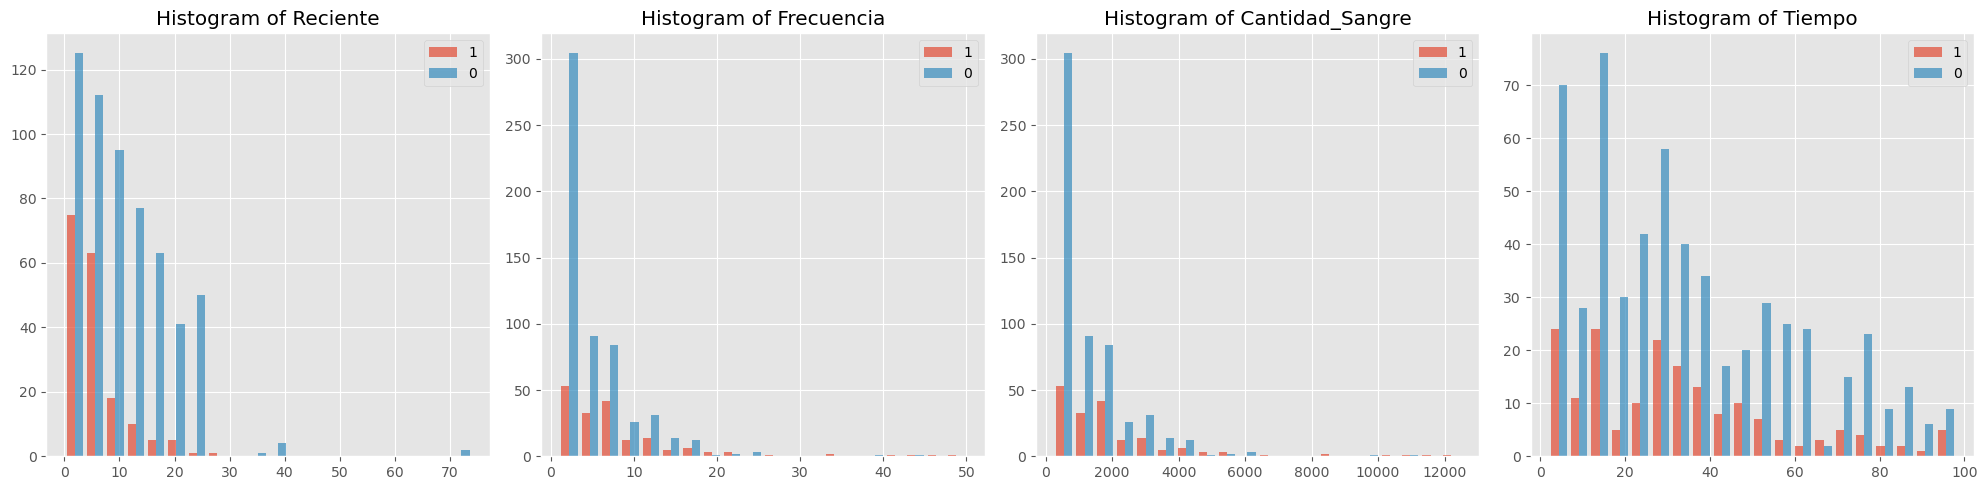

In [28]:
# Excluir la columna de la etiqueta
columns = dataset.columns[:-1]

# Crear una cuadrícula de subtramas 2x4 para histogramas y gráficos de dispersión
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Visualizar histogramas para todas las columnas
for i, column in enumerate(columns):
    axs[i].hist([dataset[dataset['Donacion_marzo'] == 1][column], 
                    dataset[dataset['Donacion_marzo'] == 0][column]], 
                   label=['1', '0'], bins=20, alpha=0.7)
    axs[i].set_title("Histogram of {}".format(column))
    axs[i].legend(loc='upper right')
# Ajustar el diseño
plt.tight_layout()
plt.show()



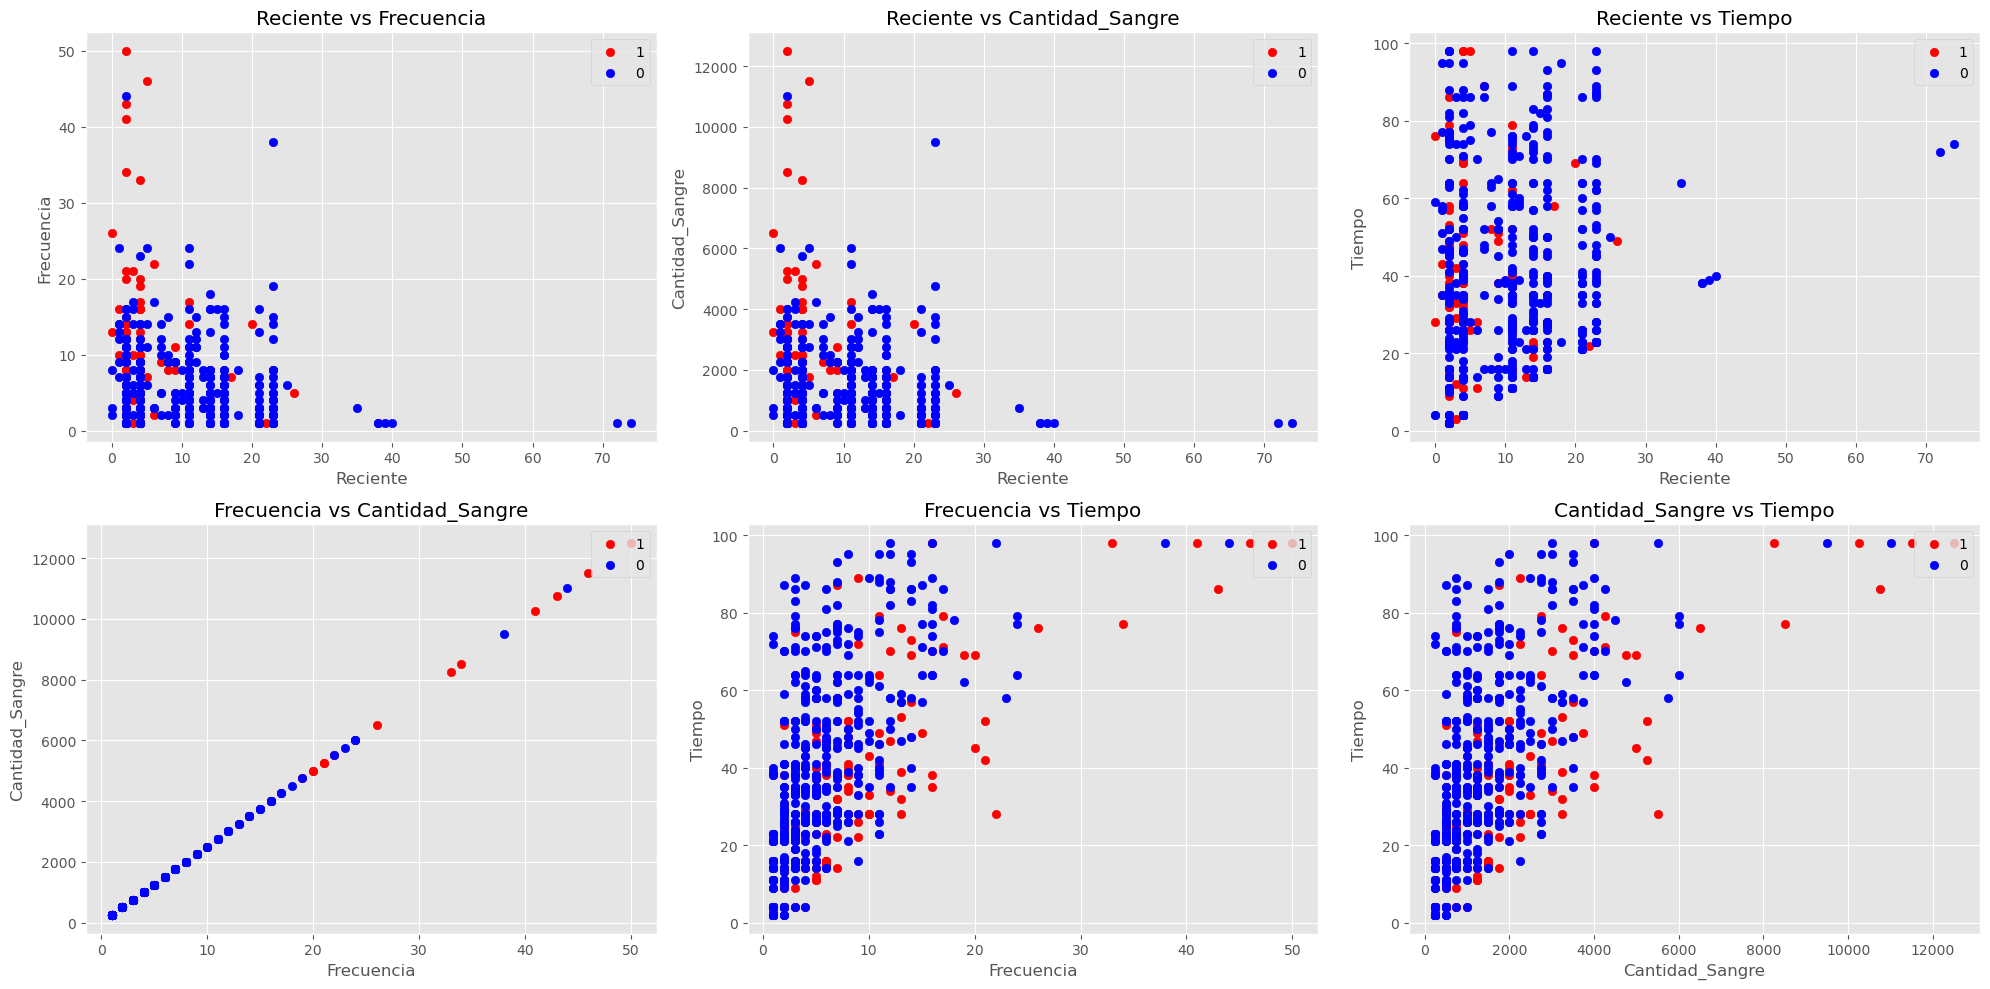

In [29]:
# Crear todas las combinaciones posibles de pares de variables
combinations = list(itertools.combinations(columns, 2))

# Calcular el número de filas necesario para acomodar todas las combinaciones
num_combinations = len(combinations)
num_rows = num_combinations // 3 + (num_combinations % 3 > 0)

# Crear una cuadrícula de subtramas con un número suficiente de filas para todas las combinaciones
fig, axs = plt.subplots(num_rows, 3, figsize=(20, num_rows * 5))  # Ajustar el tamaño de figura según sea necesario

# Visualizar gráficos de dispersión para todas las combinaciones
for j, (var1, var2) in enumerate(combinations):
    row = j // 3
    col = j % 3
    axs[row, col].scatter(dataset[dataset['Donacion_marzo'] == 1][var1], 
                          dataset[dataset['Donacion_marzo'] == 1][var2], 
                          c='red', label='1')
    axs[row, col].scatter(dataset[dataset['Donacion_marzo'] == 0][var1], 
                          dataset[dataset['Donacion_marzo'] == 0][var2], 
                          c='blue', label='0')
    axs[row, col].set_title("{} vs {}".format(var1, var2))
    axs[row, col].set_xlabel(var1)
    axs[row, col].set_ylabel(var2)
    axs[row, col].legend(loc='upper right')

# Ajustar el diseño para que no haya superposición
plt.tight_layout()

# Mostrar la figura
plt.show()

 **Nota**

- **Desequilibrio de Clases**: La primera fila de histogramas muestra un claro desequilibrio de clases entre aquellos que donaron sangre en marzo de 2007 (etiqueta '1') y aquellos que no lo hicieron (etiqueta '0'). Esto puede afectar el rendimiento del modelo de aprendizaje automático, ya que puede sesgarse hacia la clase más frecuente. Se recomienda aplicar técnicas de balanceo de clases como sobremuestreo, submuestreo o generación de datos sintéticos para manejar este desequilibrio.

- **Relación entre 'Frequency' y 'Monetary'**: La correlación directa entre 'Frequency' y 'Monetary' es evidente en el gráfico de dispersión de la esquina inferior derecha, lo que indica una relación lineal casi perfecta. Esto es coherente con la naturaleza de las variables, dado que 'Monetary' es probablemente un múltiplo de 'Frequency' (cada donación tiene un volumen fijo de sangre). Esto sugiere que una de las dos variables podría ser redundante para el modelado predictivo, y se podría considerar eliminar una para simplificar el modelo sin perder información significativa.

- **Posible correlación entre 'Time' y otras variables**: Los gráficos de dispersión 'Reciente vs Tiempo' y 'Frecuencia vs Tiempo' no muestran una relación lineal clara, pero sí sugieren algún tipo de relación. Por ejemplo, en 'Reciente vs Tiempo', hay una tendencia de que aquellos con valores más bajos de 'Reciente' tienen una distribución más amplia en 'Tiempo', lo que podría sugerir que los donantes nuevos tienden a tener un historial más corto de donaciones. Sin embargo, esta observación necesita ser investigada más a fondo, posiblemente con análisis estadísticos para establecer la fuerza y la significancia de la correlación.

- **Dispersión de los datos**: Hay una dispersión considerable en los datos, especialmente en los gráficos de dispersión 'Reciente vs Frecuencia' y 'Reciente vs Cantidad_Sangre', lo que podría indicar que la variable 'Reciente' tiene una relación menos directa con la frecuencia y la cantidad de donaciones en comparación con la relación entre 'Frecuencia' y 'Cantidad_Sangre'.


**PCA:** como observalos la relación entre 'Frequency' y 'Monetary' se podría hacer una reducción dimensional para mejorar el funconamiento de KNN 

**b)** División de los datos en entrenamiento (80%) y test (20%):

<span style="color:red">**MUY IMPORTANTE:**</span> Vamos a establecer una semilla con un valor predefinido inmediatamente antes de ejecutar cualquier operación con un componente aleatorio. Así aseguramos que nuestros resultados sean repetibles.

Esto es, vamos a poner `np.random.seed(SEED_VALUE)` antes de:
 - `fit()`
 - `predict()`
 
En aquellas funciones que lo admitan, sustituiremos el comando np.random.seed(SEED_VALUE) por el argumento `random_state=SEED_VALUE`. Por ejemplo, para la división de datos entre entrenamiento y test con `train_test_split`.

In [30]:
# tenemos mas ejemplos de una categoria que en otra si queremos hacer una experimentación para el conjunto de test 
# con stratify mantenga el mismo poncentaje de cadad clase  en el test y en el train en este 
# caso es para que train si hay 2 categorias mantenga la proporcion de estas en train y test decir que si en el total 
# tenemos 60% 1 y 40% 2 se intenta man tener el porcentaje de dataos 
dataset_train, dataset_test = train_test_split(dataset,
                            test_size=0.2, random_state=SEED_VALUE,
                                              stratify=dataset["Donacion_marzo"])
print(dataset_test.shape)
display(dataset_test.head())

(150, 5)


,Reciente,Frecuencia,Cantidad_Sangre,Tiempo,Donacion_marzo
309,16,3,750,19,0
711,23,6,1500,45,0
343,11,1,250,11,0
462,21,1,250,21,1
646,14,2,500,14,0


## Gestión de valores faltantes

En este caso, nuestro dataset no tiene valores faltantes.
Sin embargo, la sustitución de las variables predictoras por la media se llevaría a cabo de la siguiente manera. 

In [31]:
#imp = SimpleImputer(missing_values=np.nan, fill_value='mean')
#imp = imp.fit(dataset_train)  # La media la calculamos SÓLO a partir del conjunto de train

# Los valores van a ser los mismos que antes, pues no tenemos datos faltantes
#dataset_train_prep = imp.transform(dataset_train)
#dataset_test_prep = imp.transform(dataset_test)

#dataset_test_prep

`SimpleImputer` ha convertido nuestros valores a un array NumPy, por lo que sería bueno que los volviéramos a convertir en formato dataframe.

In [32]:
#dataset_train = pd.DataFrame(dataset_train_prep,
#                             columns=dataset_train.columns,
#                             index=dataset_train.index)
#dataset_test = pd.DataFrame(dataset_test_prep,
#                            columns=dataset_test.columns,
#                            index=dataset_test.index)

#dataset_test

## Separación de variables predictoras y dependientes

In [33]:
dataset_train_X = dataset_train.loc[:, NAME_BLOOD[:-1]].astype(float)
dataset_train_Y = dataset_train.loc[:, NAME_BLOOD[-1]]

print("dimension:",dataset_train_X.shape)
display(dataset_train_X.head())


dimension: (598, 4)


,Reciente,Frecuencia,Cantidad_Sangre,Tiempo
619,4.0,1.0,250.0,4.0
357,14.0,3.0,750.0,26.0
405,14.0,3.0,750.0,41.0
700,16.0,3.0,750.0,35.0
479,23.0,1.0,250.0,23.0


In [34]:
dataset_test_X = dataset_test.loc[:, NAME_BLOOD[:-1]].astype(float)
dataset_test_Y = dataset_test.loc[:, NAME_BLOOD[-1]]

print("dimension:",dataset_train_X.shape)
display(dataset_test_X.head())

dimension: (598, 4)


,Reciente,Frecuencia,Cantidad_Sangre,Tiempo
309,16.0,3.0,750.0,19.0
711,23.0,6.0,1500.0,45.0
343,11.0,1.0,250.0,11.0
462,21.0,1.0,250.0,21.0
646,14.0,2.0,500.0,14.0


## Estandarización de los datos

Esto hay que hacerlo **DESPUÉS** de dividir en conjuntos de entrenamiento y test.

Además, como es un problema de clasificación, **NO** estandarizaremos la variable dependiente. 

**IMPORTANTE : EN ESTE CASO NO ES NECESARIO USAR LA ESTANDARIZACIÓN POR COMO SE COMPORTAN LOS ARBOLES DE DECISIÓN PERO NO IMPLICA NINGUNA PERDIDA HACERLO POR LO QUE SE EJECUTARÁ**

In [41]:
scaler = StandardScaler()

scaler.fit(dataset_train_X)

dataset_train_X_scaled = scaler.transform(dataset_train_X)
dataset_test_X_scaled = scaler.transform(dataset_test_X)

#dataset_test_X_scaled

Estos son los valores con los que se ha estandarizado.

In [42]:
print("mean {}: {}  |  std {}: {}".format(NAME_BLOOD[:-1],scaler.mean_, NAME_BLOOD[:-1],scaler.scale_))

mean ['Reciente', 'Frecuencia', 'Cantidad_Sangre', 'Tiempo']: [   9.5083612     5.63712375 1409.28093645   34.87959866]  |  std ['Reciente', 'Frecuencia', 'Cantidad_Sangre', 'Tiempo']: [   7.89304107    5.89317612 1473.29403119   24.72995729]


## Empezamos con la experimentación de clasificación con arboles

Hemos visualizado y preprocesado los datos. Vamos a empezar a trabajar con nuestro predictor.

## Definimos un rango de hiperparámetros para realizar las pruebas

In [53]:

# Expected n_neighbors <= n_samples,  n_samples = 477
# Si solo necesitas el número de muestras
n_samples = dataset_train_X_scaled.shape[0]

# ('Numero de muestras:', 598) auque pone este valor al usar  GridSearchCV me indica que son 477
print("Numero de muestras:", n_samples)

hyperparameters = {
    'min_samples_split': range(2, n_samples, 1),
  
}
# hay


Numero de muestras: 598


## Comenzamos las pruebas con 5-CV

In [54]:
arbol_classifier = DecisionTreeClassifier()
modelCV = GridSearchCV(arbol_classifier,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy', # parametro  top mejores en regresion mean scare error(skle pueda dar - std)
                       return_train_score=True)  # El warning es normal, pues el ejemplo es demasiado pequeño

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer una semilla. Pero lo ponemos igualmente
modelCV.fit(dataset_train_X_scaled, dataset_train_Y)  # En KNN no hay aprendizaje en sí, pero hay que ejecutar este comando para poder hacer inferencias

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'min_samples_split': range(2, 598)},
             return_train_score=True, scoring='accuracy')

Muestra la gráfica del error de entrenamiento con validación cruzada (5-CV) frente al valor
del hiper-parámetro.
**¿Cuál es el menor error de validación cruzada, su desviación estándar
y el valor del hiper-parámetro para el que se consigue? ¿Cuál es el valor del hiper-
parámetro si se aplicase la regla de una desviación estándar? En caso de que haya varios
modelos con error mínimo, debe seleccionarse siempre el más simple (cuantos mas vecinos mas simple por que la frontera de decisión es mas suave).**

## Resultados obtenidos en 5-CV

Puede verse el ranking de los mejores

In [55]:
cv_results = pd.DataFrame(modelCV.cv_results_)

cv_results.loc[:, [ 'param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']].head()


,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
0,2,0.709118,0.053203,596
1,3,0.714118,0.039482,595
2,4,0.729146,0.032362,592
3,5,0.732451,0.039081,590
4,6,0.725756,0.042324,594


Los mejores hiperparámetros en validación serían los siguientes (aunque no siempre conviene quedarse con los mejores):

In [57]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.loc[:, [ 'param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
81,83,0.794356,0.021129,1
82,84,0.794356,0.021129,1
83,85,0.794356,0.021129,1
84,86,0.794356,0.021129,1
85,87,0.794356,0.021129,1
86,88,0.794356,0.021129,1
87,89,0.794356,0.021129,1
88,90,0.794356,0.021129,1
89,91,0.794356,0.021129,1
90,92,0.794356,0.021129,1


En el contexto de los árboles de decisión, un modelo más simple suele ser aquel con mayor valor de min_samples_split, ya que esto conduce a un árbol menos profundo y, por lo tanto, a un modelo más general. 

## Gráfica de entrenamiento

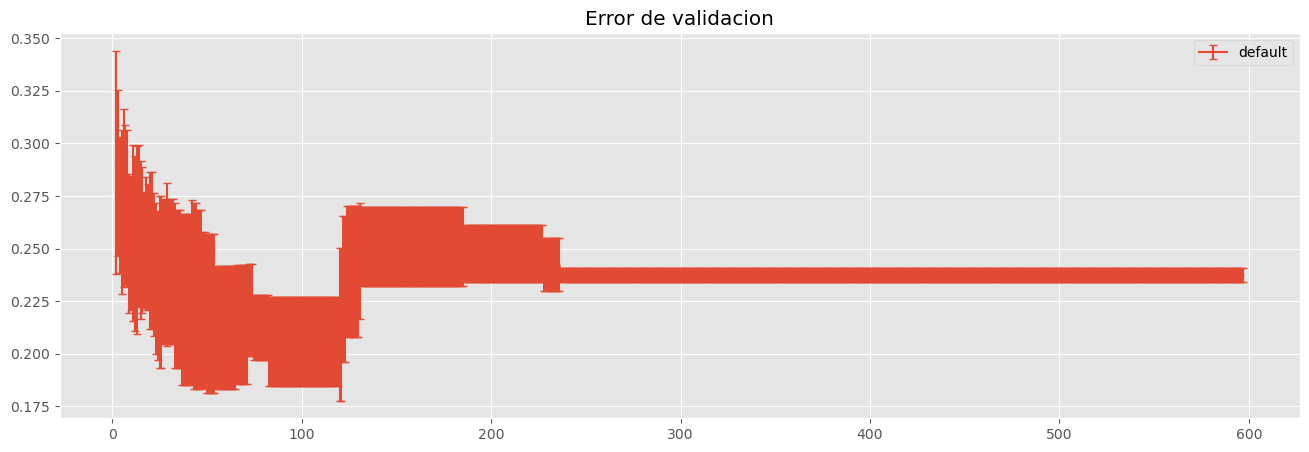

In [73]:
# separamos los pesos basados en cada 
cv_results_uniform = cv_results

plt.figure(figsize=(16, 5))  # Puedes cambiar estos valores según tus necesidades
# eje x xantidad de vecinos y en el y cuanto es el errror
plt.title("Error de validacion")
plt.errorbar(cv_results_uniform['param_min_samples_split'],1 - cv_results_uniform['mean_test_score'],
             cv_results_uniform['std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

Se observa que apartir de ciento numero de vecinos el error es constante y con la misma variación por lo que haremos un acercamiento a a la parte del grafico que  tiene variación para poder observar mejor esta sección. 

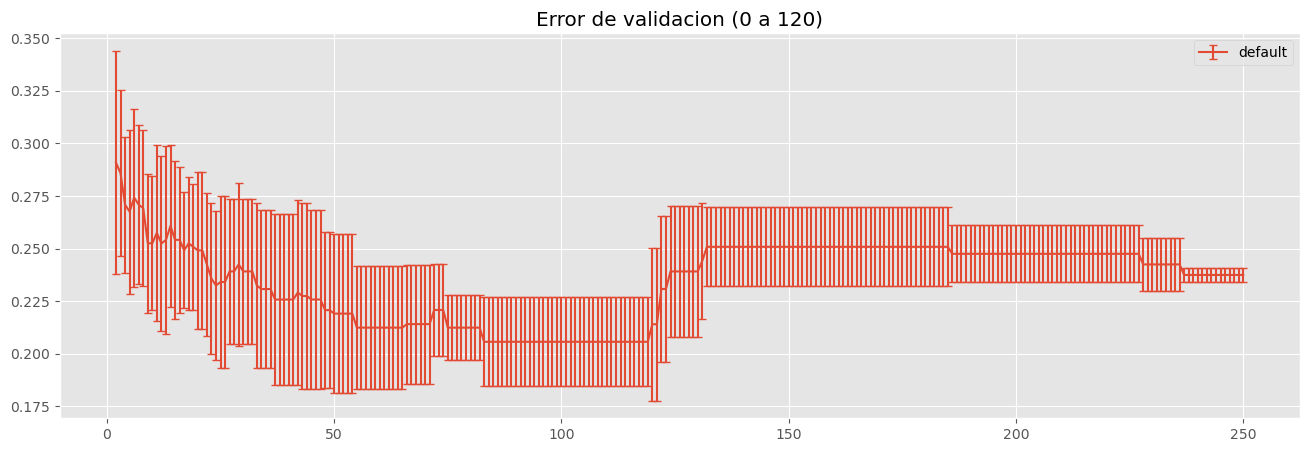

In [74]:
# Primera gráfica: De 0 a 110
plt.figure(figsize=(16, 5))
plt.title("Error de validacion (0 a 120)")
subset = cv_results_uniform[cv_results_uniform['param_min_samples_split'] <= 250]
plt.errorbar(subset['param_min_samples_split'],1 - subset['mean_test_score'],
             subset['std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

In [75]:
# Resultados obtenidos en 5-CV
cv_results = pd.DataFrame(modelCV.cv_results_)
# Guardar los resultados completos en un archivo CSV
cv_results.to_csv('cv_results.csv', index=False)

# Filtrar y guardar los mejores resultados
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.to_csv('cv_results_best.csv', index=False)

# Separar los resultados por tipo de peso y guardarlos
cv_results_uniform = cv_results
cv_results_uniform.to_csv('cv_results_uniform.csv', index=False)


In [76]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1].sort_values(by='param_min_samples_split')
cv_results_best.loc[:, [ 'param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
81,83,0.794356,0.021129,1
82,84,0.794356,0.021129,1
83,85,0.794356,0.021129,1
84,86,0.794356,0.021129,1
85,87,0.794356,0.021129,1
86,88,0.794356,0.021129,1
87,89,0.794356,0.021129,1
88,90,0.794356,0.021129,1
89,91,0.794356,0.021129,1
90,92,0.794356,0.021129,1


In [110]:
columna_show=[ 'param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']
best_value=cv_results_best.loc[:, columna_show]
best_value_ind=best_value.index[-1]

In [112]:
best_value_ind

117

In [120]:
def get_val_cross_validater(df,indice_inicio=2):
    # Inicializar 'valor_anterior' con el último valor en el rango de búsqueda
    valor_anterior = df['param_min_samples_split'][indice_inicio]

    for i in range(indice_inicio, len(df) - 1):
        if df['param_min_samples_split'][i] != df['param_min_samples_split'][i + 1] + 1:
            valor_anterior = df['param_min_samples_split'][i]
            break

    return valor_anterior

In [121]:
# Aplicar la regla de una desviación estándar
best_model = cv_results[cv_results['rank_test_score'] == 1].sort_values(by='param_min_samples_split').iloc[0]
mejor_score = best_model['mean_test_score']
mejor_std = best_model['std_test_score']


threshold =  mejor_score -  mejor_std

cv_results_aux = cv_results[
     cv_results['mean_test_score']>= threshold
].sort_values(by='param_min_samples_split', ascending=False)

cv_results_aux = cv_results_aux.loc[:, [
    'param_min_samples_split',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
]

cv_results_aux = cv_results_aux.sort_values(by='param_min_samples_split',ascending=False)
display(cv_results_aux.head())
valor_ind=cv_results_aux.index[0]

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
119,121,0.786022,0.036395,57
118,120,0.786022,0.036395,57
117,119,0.794356,0.021129,1
116,118,0.794356,0.021129,1
115,117,0.794356,0.021129,1


In [126]:
valor_ind_cruzado=get_val_cross_validater(cv_results_aux.sort_values(by='param_min_samples_split',ascending=True),best_value_ind)
print(valor_ind_cruzado)

119


In [127]:
cv_results_aux = cv_results_aux.sort_values(by='param_min_samples_split')
display(cv_results_aux)

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
35,37,0.774272,0.040488,75
36,38,0.774272,0.040488,75
37,39,0.774272,0.040488,75
38,40,0.774272,0.040488,75
39,41,0.774272,0.040488,75
...,...,...,...,...
115,117,0.794356,0.021129,1
116,118,0.794356,0.021129,1
117,119,0.794356,0.021129,1
118,120,0.786022,0.036395,57




Siendo la gráfica que usamos para decidir los valores de los hiper-parámetros (mediante la regla de una desviación estándar), supongamos que cualquier valor que en su desviación cruce com la linea generada en color azul , e un valor a tener encuenta, tambien permitimos que visualizar el error minimo obtenido en verde:


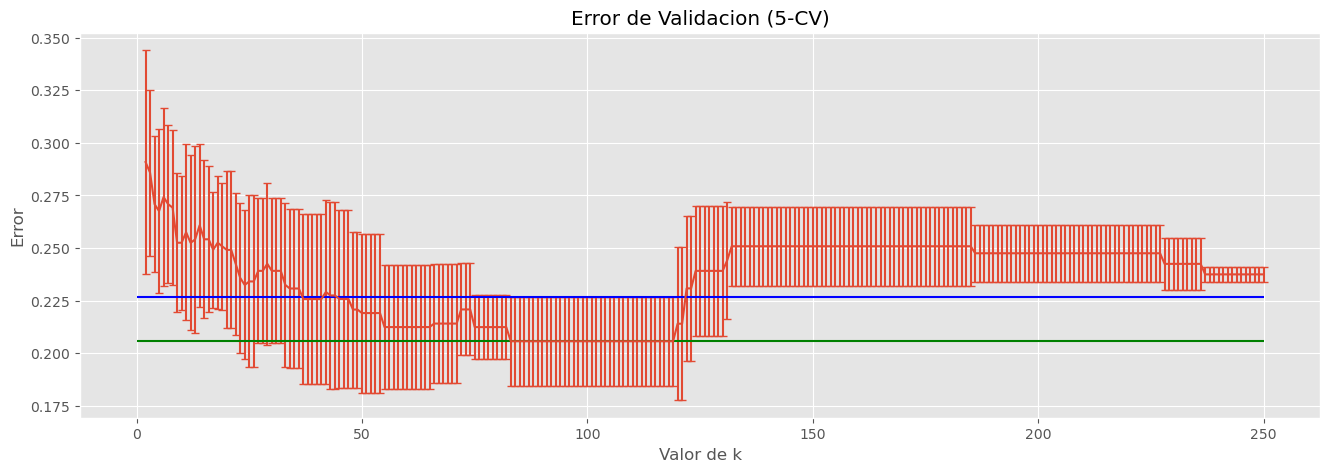

In [128]:

fig, ax = plt.subplots(figsize=(16, 5), ncols=1, nrows=1)
ax.set_title("Error de Validacion (5-CV)")

ax.set_xlabel("Valor de k")
ax.set_ylabel("Error")
subset = cv_results_uniform[cv_results_uniform['param_min_samples_split'] <= 250]
ax.errorbar(subset['param_min_samples_split'],1 - subset['mean_test_score'],
             subset['std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
ax.hlines(y=1-threshold, xmin=0, xmax=250, colors='blue')

ax.hlines(y=1-mejor_score, xmin=0, xmax=250, colors='green')

El valor que escogeríamos por tanto sería:

**Para validación cruzada**

In [132]:
display(cv_results.loc[best_value_ind:best_value_ind, columna_show])

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
117,119,0.794356,0.021129,1


**Para la regla deviación estandar**

In [133]:
display(cv_results.loc[valor_ind_cruzado:valor_ind_cruzado, columna_show])

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
119,121,0.786022,0.036395,57


Muestra la gráfica del error de test frente al valor del hiper-parámetro, y valora si la gráfica
del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de test.**¿Cuál es el error de test para el valor del hiper-parámetro seleccionado por la validación cruzada?**

## Verificación de nuestros hiperparámetros

Esto no se haría **JAMÁS** en una situación real.
Pero como este es un ejemplo para aprender, vamos a ver cómo de lejos nos hemos quedado de los hiperparámetros "ideales".

Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo (80% de los datos) y nuestro conjunto de validación va a ser el conjunto de test (20% de los datos).

In [135]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y])

arbol_classifier = DecisionTreeClassifier()
modelCV_test = GridSearchCV(arbol_classifier,
                       hyperparameters,
                       cv=ps,
                       scoring='accuracy', # parametro  top mejores en regresion mean scare error(skle pueda dar - std)
                       return_train_score=True)  # El warning es normal, pues el ejemplo es demasiado pequeño


np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer semilla. Pero lo ponemos igualmente
modelCV_test.fit(dataset_all_X_scaled, dataset_all_Y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeClassifier(),
             param_grid={'min_samples_split': range(2, 598)},
             return_train_score=True, scoring='accuracy')

In [137]:
test_results = pd.DataFrame(modelCV_test.cv_results_)
test_results.loc[:, [ 'param_min_samples_split', 'mean_test_score', 'rank_test_score']].head()

,param_min_samples_split,mean_test_score,rank_test_score
0,2,0.693333,592
1,3,0.693333,592
2,4,0.700000,591
3,5,0.680000,595
4,6,0.680000,595


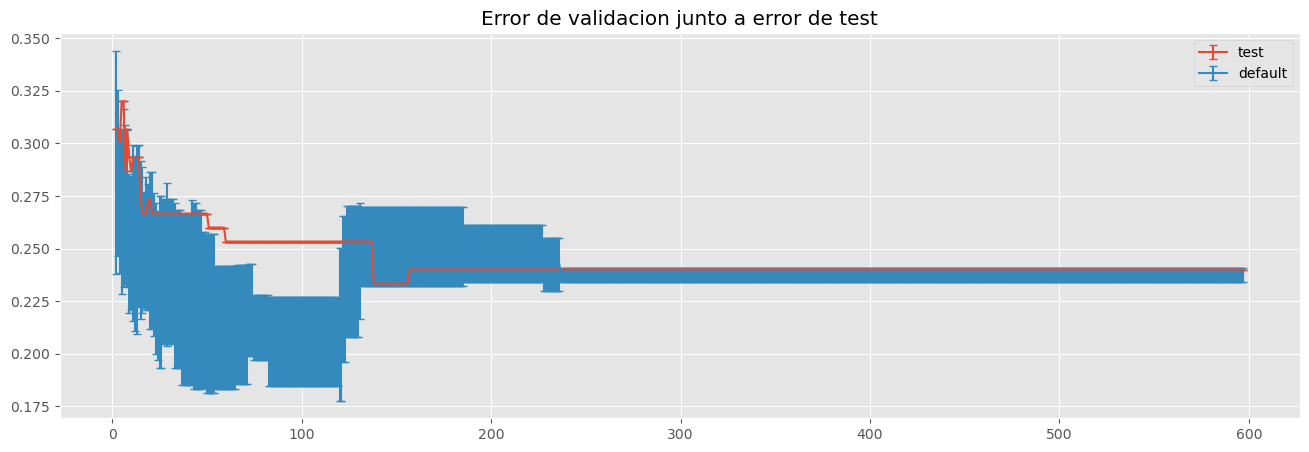

In [141]:
plt.figure(figsize=(16, 5))  # Puedes cambiar estos valores según tus necesidades
# eje x xantidad de vecinos y en el y cuanto es el errror
plt.title("Error de validacion junto a error de test")
plt.errorbar(test_results['param_min_samples_split'],1 - test_results['mean_test_score'],
             test_results['std_test_score'], label='test', capsize=3)  # 1 - [] para imprimir el error
plt.errorbar(cv_results_uniform['param_min_samples_split'],1 - cv_results_uniform['mean_test_score'],
             cv_results_uniform['std_test_score'], label='default', capsize=3) 
plt.legend(loc='upper right')
plt.show()

Apartir de ciertos vecinos visualizamos el mismo error que como en el entrenamiento haremos un un acercamiento sobre la parte de intereres

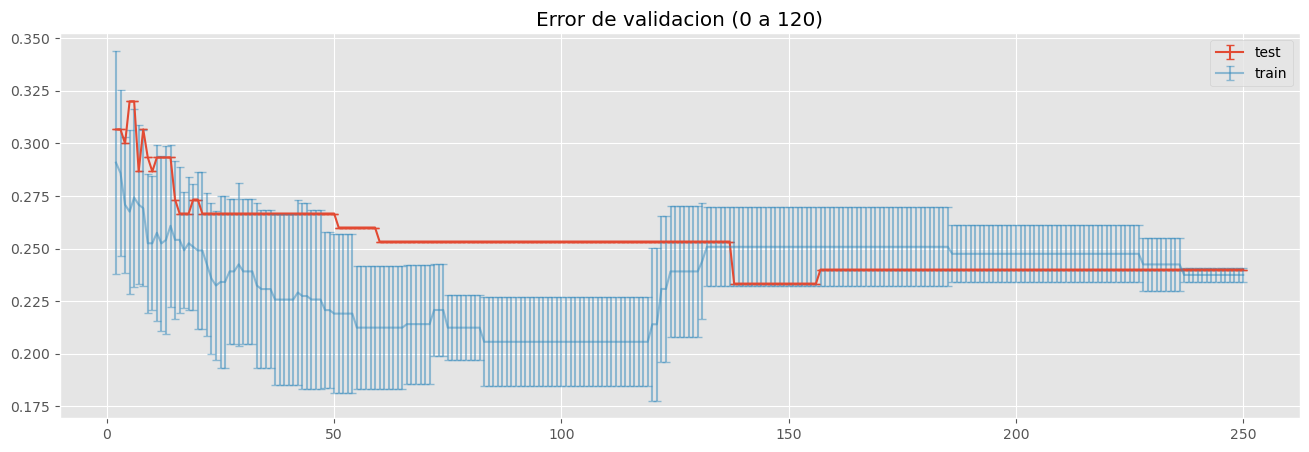

In [144]:
plt.figure(figsize=(16, 5))
plt.title("Error de validacion (0 a 120)")
subset = cv_results_uniform[cv_results_uniform['param_min_samples_split'] <= 250]
subset_test= test_results[test_results['param_min_samples_split']<= 250]
plt.errorbar(subset_test['param_min_samples_split'],1 - subset_test['mean_test_score'],
             subset_test['std_test_score'], label='test', capsize=3)  # 1 - [] para imprimir el error

plt.errorbar(subset['param_min_samples_split'],1 - subset['mean_test_score'],
             subset['std_test_score'], label='train', capsize=3,alpha=0.5)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

In [148]:
columna_show=[ 'param_min_samples_split', 'mean_test_score', 'rank_test_score']

In [150]:
cv_results_best_test = test_results[test_results['rank_test_score'] == 1].sort_values(by='param_min_samples_split')
cv_results_best_test.loc[:,columna_show]

,param_min_samples_split,mean_test_score,rank_test_score
136,138,0.766667,1
137,139,0.766667,1
138,140,0.766667,1
139,141,0.766667,1
140,142,0.766667,1
141,143,0.766667,1
142,144,0.766667,1
143,145,0.766667,1
144,146,0.766667,1
145,147,0.766667,1


**Modelo selecionado con la validación cruzada**

In [153]:
test_results.loc[best_value_ind:best_value_ind, columna_show]

,param_min_samples_split,mean_test_score,rank_test_score
117,119,0.746667,461


**Modelo seleciondo con la regla de la desviación estandar**

In [154]:
test_results.loc[valor_ind_cruzado:valor_ind_cruzado,columna_show]

,param_min_samples_split,mean_test_score,rank_test_score
119,121,0.746667,461


In [158]:
# Aplicar la regla de una desviación estándar
best_model = cv_results[cv_results['rank_test_score'] == 1].sort_values(by='param_min_samples_split').iloc[0]
mejor_score = best_model['mean_test_score']
mejor_std = best_model['std_test_score']


#cv_results_best_error_plus_std =  mejor_error -  mejor_std

cv_results_aux = cv_results[
     cv_results['mean_test_score']>= threshold
].sort_values(by='param_min_samples_split', ascending=False)

cv_results_aux = cv_results_aux.loc[:, [
    'param_min_samples_split',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
]

cv_results_aux = cv_results_aux.sort_values(by='param_min_samples_split')
cv_results_aux

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
35,37,0.774272,0.040488,75
36,38,0.774272,0.040488,75
37,39,0.774272,0.040488,75
38,40,0.774272,0.040488,75
39,41,0.774272,0.040488,75
...,...,...,...,...
115,117,0.794356,0.021129,1
116,118,0.794356,0.021129,1
117,119,0.794356,0.021129,1
118,120,0.786022,0.036395,57


### Prueba a la hora de usar menos dimesiones

Como se comentó anterior mente  exitste una relación entre 'Frequency' y 'Monetary' por lo que se quiere observar si al reducir las dimensiones eliminando Frequency o Monetary hay mejoras, baja el rendimiento o se comporta de manera similar

In [191]:
dataset_train_X_reduce = dataset_train.loc[:,["Reciente","Frecuencia","Tiempo"]].astype(float)

dataset_test_X_reduce = dataset_test.loc[:, ["Reciente","Frecuencia","Tiempo"]].astype(float)


scaler = StandardScaler()

scaler.fit(dataset_train_X_reduce)

dataset_train_X_reduce_scaled = scaler.transform(dataset_train_X_reduce)
dataset_test_X_reduce_scaled = scaler.transform(dataset_test_X_reduce)

dataset_test_X_scaled

# ('Numero de muestras:', 598) auque pone este valor al usar  GridSearchCV me indica que son 477
print("Numero de muestras:", n_samples)

hyperparameters = {
     'min_samples_split': range(2, n_samples, 1)}
# hay
arbol_classifier = DecisionTreeClassifier()
modelCV_reduce = GridSearchCV(arbol_classifier,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy', # parametro  top mejores en regresion mean scare error(skle pueda dar - std)
                       return_train_score=True)  # El warning es normal, pues el ejemplo es demasiado pequeño

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer una semilla. Pero lo ponemos igualmente
modelCV_reduce.fit(dataset_train_X_reduce, dataset_train_Y)  # En KNN no hay aprendizaje en sí, pero hay que ejecutar este comando para poder hacer inferencias

Numero de muestras: 598


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'min_samples_split': range(2, 598)},
             return_train_score=True, scoring='accuracy')

In [192]:
cv_results_reduce = pd.DataFrame(modelCV_reduce.cv_results_)
cv_results.loc[:, columna_show].head()

,param_min_samples_split,mean_test_score,rank_test_score
0,2,0.709118,596
1,3,0.714118,595
2,4,0.729146,592
3,5,0.732451,590
4,6,0.725756,594


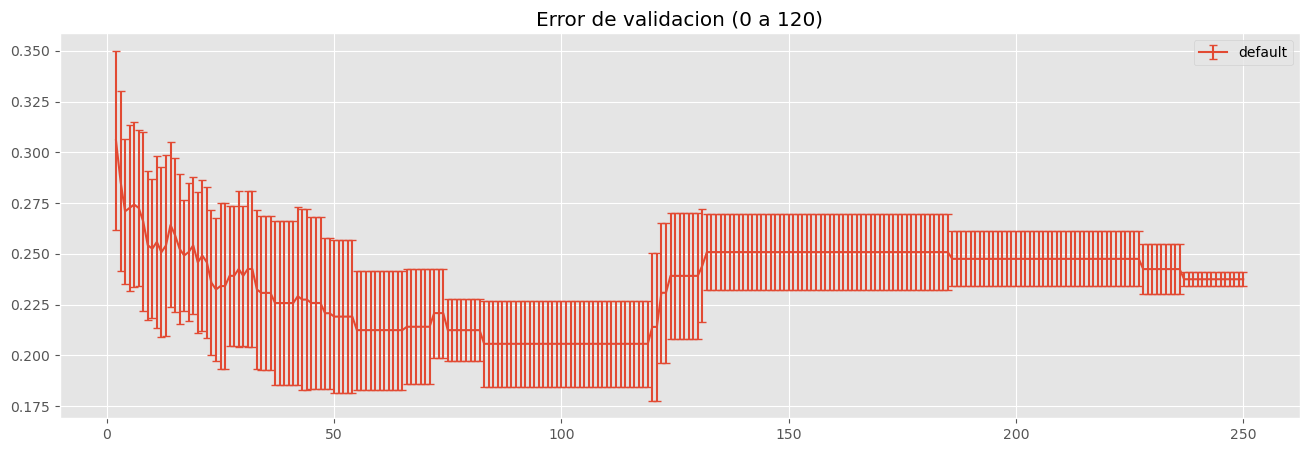

In [193]:
# Primera gráfica: De 0 a 110
plt.figure(figsize=(16, 5))
plt.title("Error de validacion (0 a 120)")
subset = cv_results_reduce[cv_results_reduce['param_min_samples_split'] <= 250]
plt.errorbar(subset['param_min_samples_split'],1 - subset['mean_test_score'],
             subset['std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

**Nota** Como podemos observar tiene un comportamiento similar que usar la variable comprobemos el resto de pasos


In [194]:
cv_results_best = cv_results_reduce[cv_results_reduce['rank_test_score'] == 1].sort_values(by='param_min_samples_split')
cv_results_best.loc[:, [ 'param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
81,83,0.794356,0.021129,1
82,84,0.794356,0.021129,1
83,85,0.794356,0.021129,1
84,86,0.794356,0.021129,1
85,87,0.794356,0.021129,1
86,88,0.794356,0.021129,1
87,89,0.794356,0.021129,1
88,90,0.794356,0.021129,1
89,91,0.794356,0.021129,1
90,92,0.794356,0.021129,1


In [195]:
# Aplicar la regla de una desviación estándar
best_model = cv_results_reduce[cv_results_reduce['rank_test_score'] == 1].sort_values(by='param_min_samples_split').iloc[0]
mejor_score = best_model['mean_test_score']
mejor_std = best_model['std_test_score']


threshold =  mejor_score -  mejor_std

cv_results_aux = cv_results[
     cv_results['mean_test_score']>= threshold
].sort_values(by='param_min_samples_split', ascending=False)

cv_results_aux = cv_results_aux.loc[:, [
    'param_min_samples_split',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
]

cv_results_aux = cv_results_aux.sort_values(by='param_min_samples_split',ascending=False)
cv_results_aux.head()

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
119,121,0.786022,0.036395,57
118,120,0.786022,0.036395,57
117,119,0.794356,0.021129,1
116,118,0.794356,0.021129,1
115,117,0.794356,0.021129,1


In [196]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_reduce_scaled, dataset_test_X_reduce_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y])

arbol_classifier = DecisionTreeClassifier()
modelCV_test_reduce = GridSearchCV(arbol_classifier,
                       hyperparameters,
                       cv=ps,
                       scoring='accuracy',
                       return_train_score=True)

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer semilla. Pero lo ponemos igualmente
modelCV_test_reduce.fit(dataset_all_X_scaled, dataset_all_Y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeClassifier(),
             param_grid={'min_samples_split': range(2, 598)},
             return_train_score=True, scoring='accuracy')

In [197]:
test_results_reduce = pd.DataFrame(modelCV_test_reduce.cv_results_)
#test_results.loc[:, [ 'param_n_neighbors', 'mean_test_score', 'rank_test_score']]

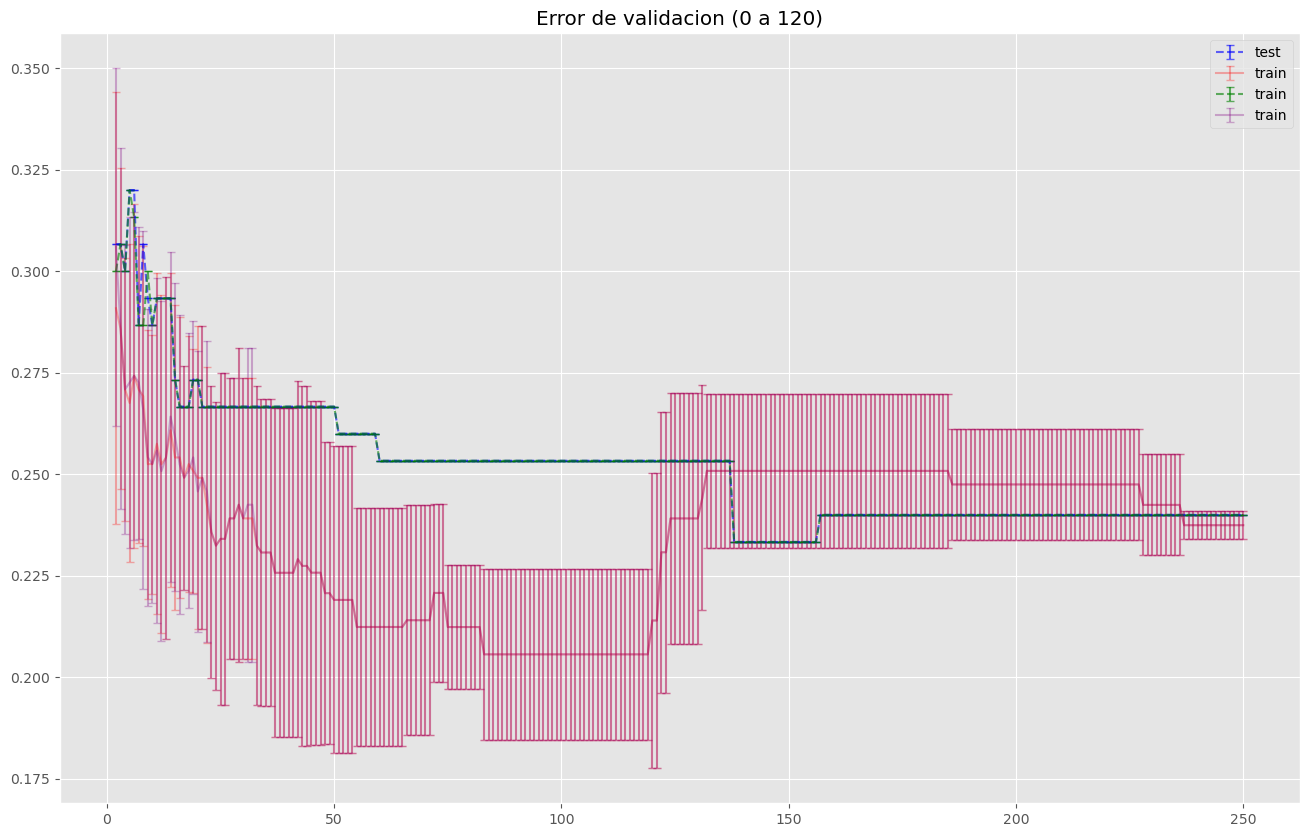

In [198]:
plt.figure(figsize=(16, 10))
plt.title("Error de validacion (0 a 120)")

subset_reduce = cv_results_reduce[test_results_reduce['param_min_samples_split'] <= 250]

subset_test_reduce= test_results_reduce[test_results['param_min_samples_split']<= 250]

subset = cv_results[cv_results['param_min_samples_split'] <= 250]

subset_test= test_results[test_results['param_min_samples_split']<= 250]

plt.errorbar(subset_test['param_min_samples_split'],1 - subset_test['mean_test_score'],
             subset_test['std_test_score'], label='test', capsize=3,alpha=0.6,  color='blue',linestyle='--')  # 1 - [] para imprimir el error

plt.errorbar(subset['param_min_samples_split'],1 - subset['mean_test_score'],
             subset['std_test_score'], label='train', capsize=3,alpha=0.3, color='red', )  # 1 - [] para imprimir el error

plt.errorbar(subset_test_reduce['param_min_samples_split'],1 - subset_test_reduce['mean_test_score'],
             subset_test_reduce['std_test_score'], label='train', capsize=3,alpha=0.6,  color='green', linestyle='--')  # 1 - [] para imprimir el error

plt.errorbar(subset_reduce['param_min_samples_split'],1 - subset_reduce['mean_test_score'],
             subset_reduce['std_test_score'], label='train', capsize=3,alpha=0.3, color='purple')  # 1 - [] para imprimir el error

plt.legend(loc='upper right')
plt.show()

In [199]:
cv_results_best_test = subset_test_reduce[subset_test_reduce['rank_test_score'] == 1].sort_values(by='param_min_samples_split')
cv_results_best_test.loc[:, [ 'param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
136,138,0.766667,0.0,1
137,139,0.766667,0.0,1
138,140,0.766667,0.0,1
139,141,0.766667,0.0,1
140,142,0.766667,0.0,1
141,143,0.766667,0.0,1
142,144,0.766667,0.0,1
143,145,0.766667,0.0,1
144,146,0.766667,0.0,1
145,147,0.766667,0.0,1


**Modelo selecionado por validación cruzada**

In [200]:
subset_test_reduce.loc[best_value_ind:best_value_ind, [ 'param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
117,119,0.746667,0.0,461


**Modelo selecionado por regla de la desviación estándar**

In [201]:
subset_test_reduce.loc[valor_ind_cruzado:valor_ind_cruzado, [ 'param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
119,121,0.746667,0.0,461


En ambos casos comprobamos que los modelos selecionados empeoran entre 1.4 % en comparación 

Comprobamdo si se encuentra un minimo global entre el 20 y el 26 o entorno al 40

En comparación con el de usar todos los modelos hay cierta mejora permitiendo que haya una mayor simplificación del modelo ya que al usar mas vecino suavizamos la frontera

Otro tipo de reduccion

In [202]:
dataset_train_X_reduce = dataset_train.loc[:,["Reciente","Frecuencia","Cantidad_Sangre"]].astype(float)

dataset_test_X_reduce = dataset_test.loc[:, ["Reciente","Frecuencia","Cantidad_Sangre"]].astype(float)


scaler = StandardScaler()

scaler.fit(dataset_train_X_reduce)

dataset_train_X_reduce_scaled = scaler.transform(dataset_train_X_reduce)
dataset_test_X_reduce_scaled = scaler.transform(dataset_test_X_reduce)

dataset_test_X_scaled

# ('Numero de muestras:', 598) auque pone este valor al usar  GridSearchCV me indica que son 477
print("Numero de muestras:", n_samples)


# hay
arbol_clasificador = DecisionTreeClassifier()
modelCV_reduce_2 = GridSearchCV(arbol_clasificador,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy', # parametro  top mejores en regresion mean scare error(skle pueda dar - std)
                       return_train_score=True)  # El warning es normal, pues el ejemplo es demasiado pequeño

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer una semilla. Pero lo ponemos igualmente
modelCV_reduce_2.fit(dataset_train_X_reduce, dataset_train_Y)  # En KNN no hay aprendizaje en sí, pero hay que ejecutar este comando para poder hacer inferencias

Numero de muestras: 598


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'min_samples_split': range(2, 598)},
             return_train_score=True, scoring='accuracy')

In [203]:
modelCV_reduce_2.fit(dataset_train_X_reduce, dataset_train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'min_samples_split': range(2, 598)},
             return_train_score=True, scoring='accuracy')

In [205]:
cv_results_reduce_2 = pd.DataFrame(modelCV_reduce_2.cv_results_)
cv_results.loc[:, columna_show].head()

,param_min_samples_split,mean_test_score,rank_test_score
0,2,0.709118,596
1,3,0.714118,595
2,4,0.729146,592
3,5,0.732451,590
4,6,0.725756,594


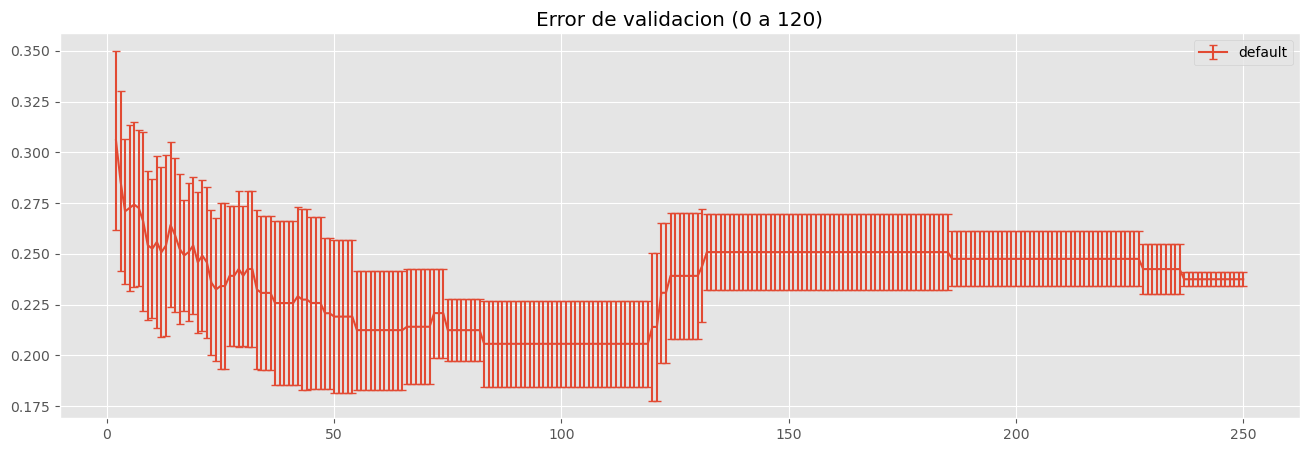

In [207]:
# Primera gráfica: De 0 a 110
plt.figure(figsize=(16, 5))
plt.title("Error de validacion (0 a 120)")
subset = cv_results_reduce[cv_results_reduce['param_min_samples_split'] <= 250]
plt.errorbar(subset['param_min_samples_split'],1 - subset['mean_test_score'],
             subset['std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

In [209]:
cv_results_best = cv_results_reduce_2[cv_results_reduce_2['rank_test_score'] == 1].sort_values(by='param_min_samples_split')
cv_results_best.loc[:, columna_show]

,param_min_samples_split,mean_test_score,rank_test_score
51,53,0.772563,1
52,54,0.772563,1
53,55,0.772563,1
54,56,0.772563,1
55,57,0.772563,1
56,58,0.772563,1
57,59,0.772563,1
58,60,0.772563,1
59,61,0.772563,1
60,62,0.772563,1


EL comportamientoe es peor como podemos observar almenos en el train

Se ve que empeora como se comento anteriormente en comparacion a lo anterior

### Ejercio 3.

Repite el ejercicio 2 pero para el problema de regresión [Energy Efficiency](https://archive.ics.uci.edu/dataset/242/energy+efficiency) con la variable de salida
cooling load. Al ser un problema de regresión deberás utilizar KNeighborsRegressor, y como medida
de error de entrenamiento y test el MSE.

Nota. Al ser un problema de regresión, para estimar tanto el error de entrenamiento como el de
test (MSE) es necesario desestandarizar los errores calculados. Para desestandarizar el campo
`mean_test_score`, únicamente será necesario multiplicar cada valor por la varianza (cuadrado de la
desviación estándar) de las observaciones de Y del conjunto de entrenamiento. No se debe restar la
media, ya que los campos `splitX_test_score` se calculan como la diferencia entre el valor de
groundtruth y la predicción para cada dato de test, por lo que todas las operaciones de adición o
substracción ya se han tenido en cuenta. De forma similar, para desestandarizar el campo
`std_test_score`, únicamente será necesario multiplicar cada valor por la varianza de las
observaciones de Y del conjunto de entrenamiento.



In [211]:
!pwd

/home/alourido/Desktop/Master_de_big_data_USC/Statistical_learning/practices/5_


In [212]:
DATASET_ENERGY='./data/energy+efficiency/EnergyEfficiency.data'
# Leer el archivo de datos y obtener la primera fila como nombres de columnas
data = pd.read_csv(DATASET_ENERGY)
NAME_ENERGY = data.columns.tolist()
#print(NAME_ENERGY)
#NAME_ENERGY=["Reciente","Frecuencia","Cantidad_Sangre","Tiempo","Donacion_marzo"]


if os.path.exists(DATASET_ENERGY):
    dataset_energy = pd.read_csv(DATASET_ENERGY, 
                          delimiter=DATASET_DELIMITER,
                          header=None,
                          skiprows=1,
                          names = NAME_ENERGY)
else:
    dataset_energy = d.DataFrame(np.array(
    [[0, 3, 2, 1], 
    [3, 0, 3, 0], 
    [0, 3, -1, 0], 
    [3, 0, 0, 1], 
    [1, 2, 1, 1], 
    [2, 1, 0, 0]]), columns=['X1', 'X2', 'X3', 'Y'])
    
dataset_energy.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y2\t\t
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,28.28


In [213]:
print('Tipo del dato de cada columna:')
print(dataset_energy.dtypes)
# Comprobamos si hay nan
print("\n Cantidad de valores NaN en cada columna:")
dataset_energy.isna().sum()

Tipo del dato de cada columna:
X1        float64
X2        float64
X3        float64
X4        float64
X5        float64
X6          int64
X7        float64
X8          int64
Y2\t\t    float64
dtype: object

 Cantidad de valores NaN en cada columna:


X1        0
X2        0
X3        0
X4        0
X5        0
X6        0
X7        0
X8        0
Y2\t\t    0
dtype: int64

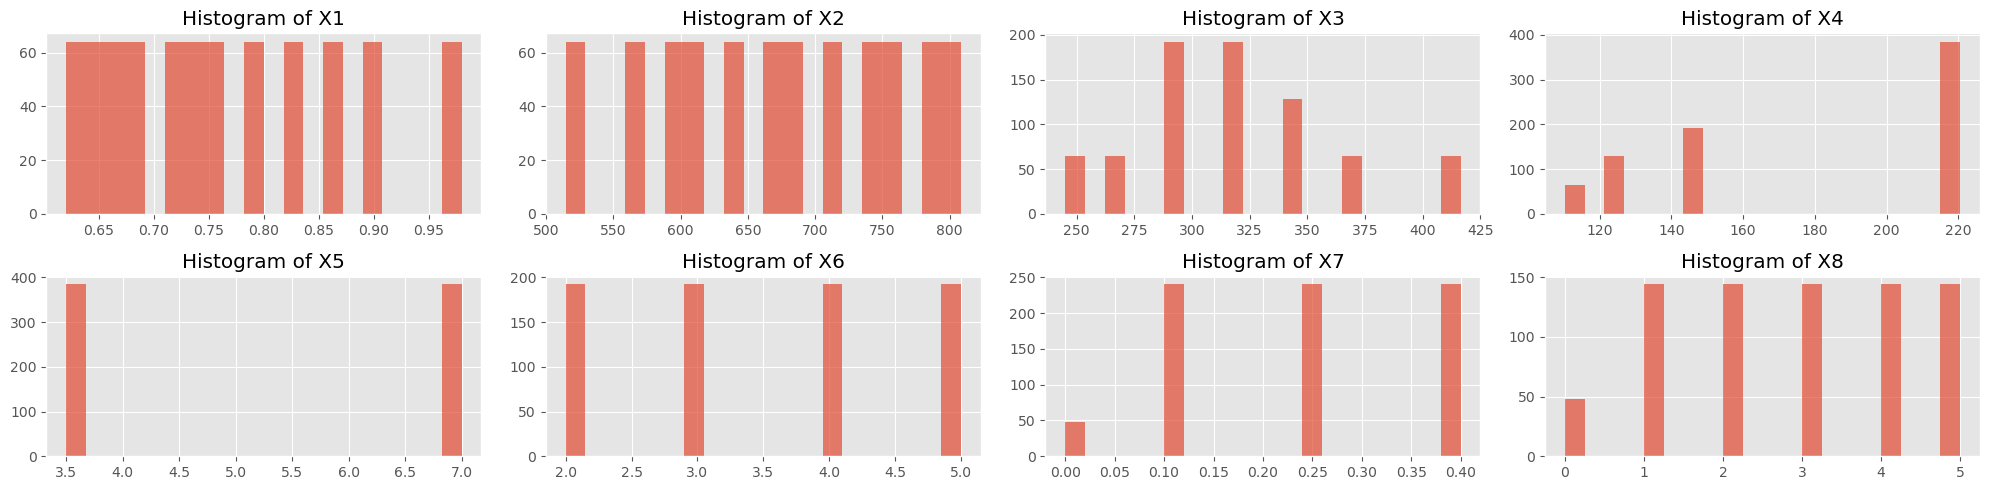

In [214]:
# Excluir la columna de la etiqueta
columns = dataset_energy.columns[:-1]

# Crear una cuadrícula de subtramas 2x4 para histogramas y gráficos de dispersión
fig, axs = plt.subplots(2, 4, figsize=(20, 5))

# Visualizar histogramas para todas las columnas
for i, column in enumerate(columns):
    row = i // 4  # Determinar la fila de la subtrama
    col = i % 4   # Determinar la columna de la subtrama
    axs[row, col].hist(dataset_energy[column], bins=20, alpha=0.7)
    axs[row, col].set_title("Histogram of {}".format(column))
# Ajustar el diseño
plt.tight_layout()
plt.show()

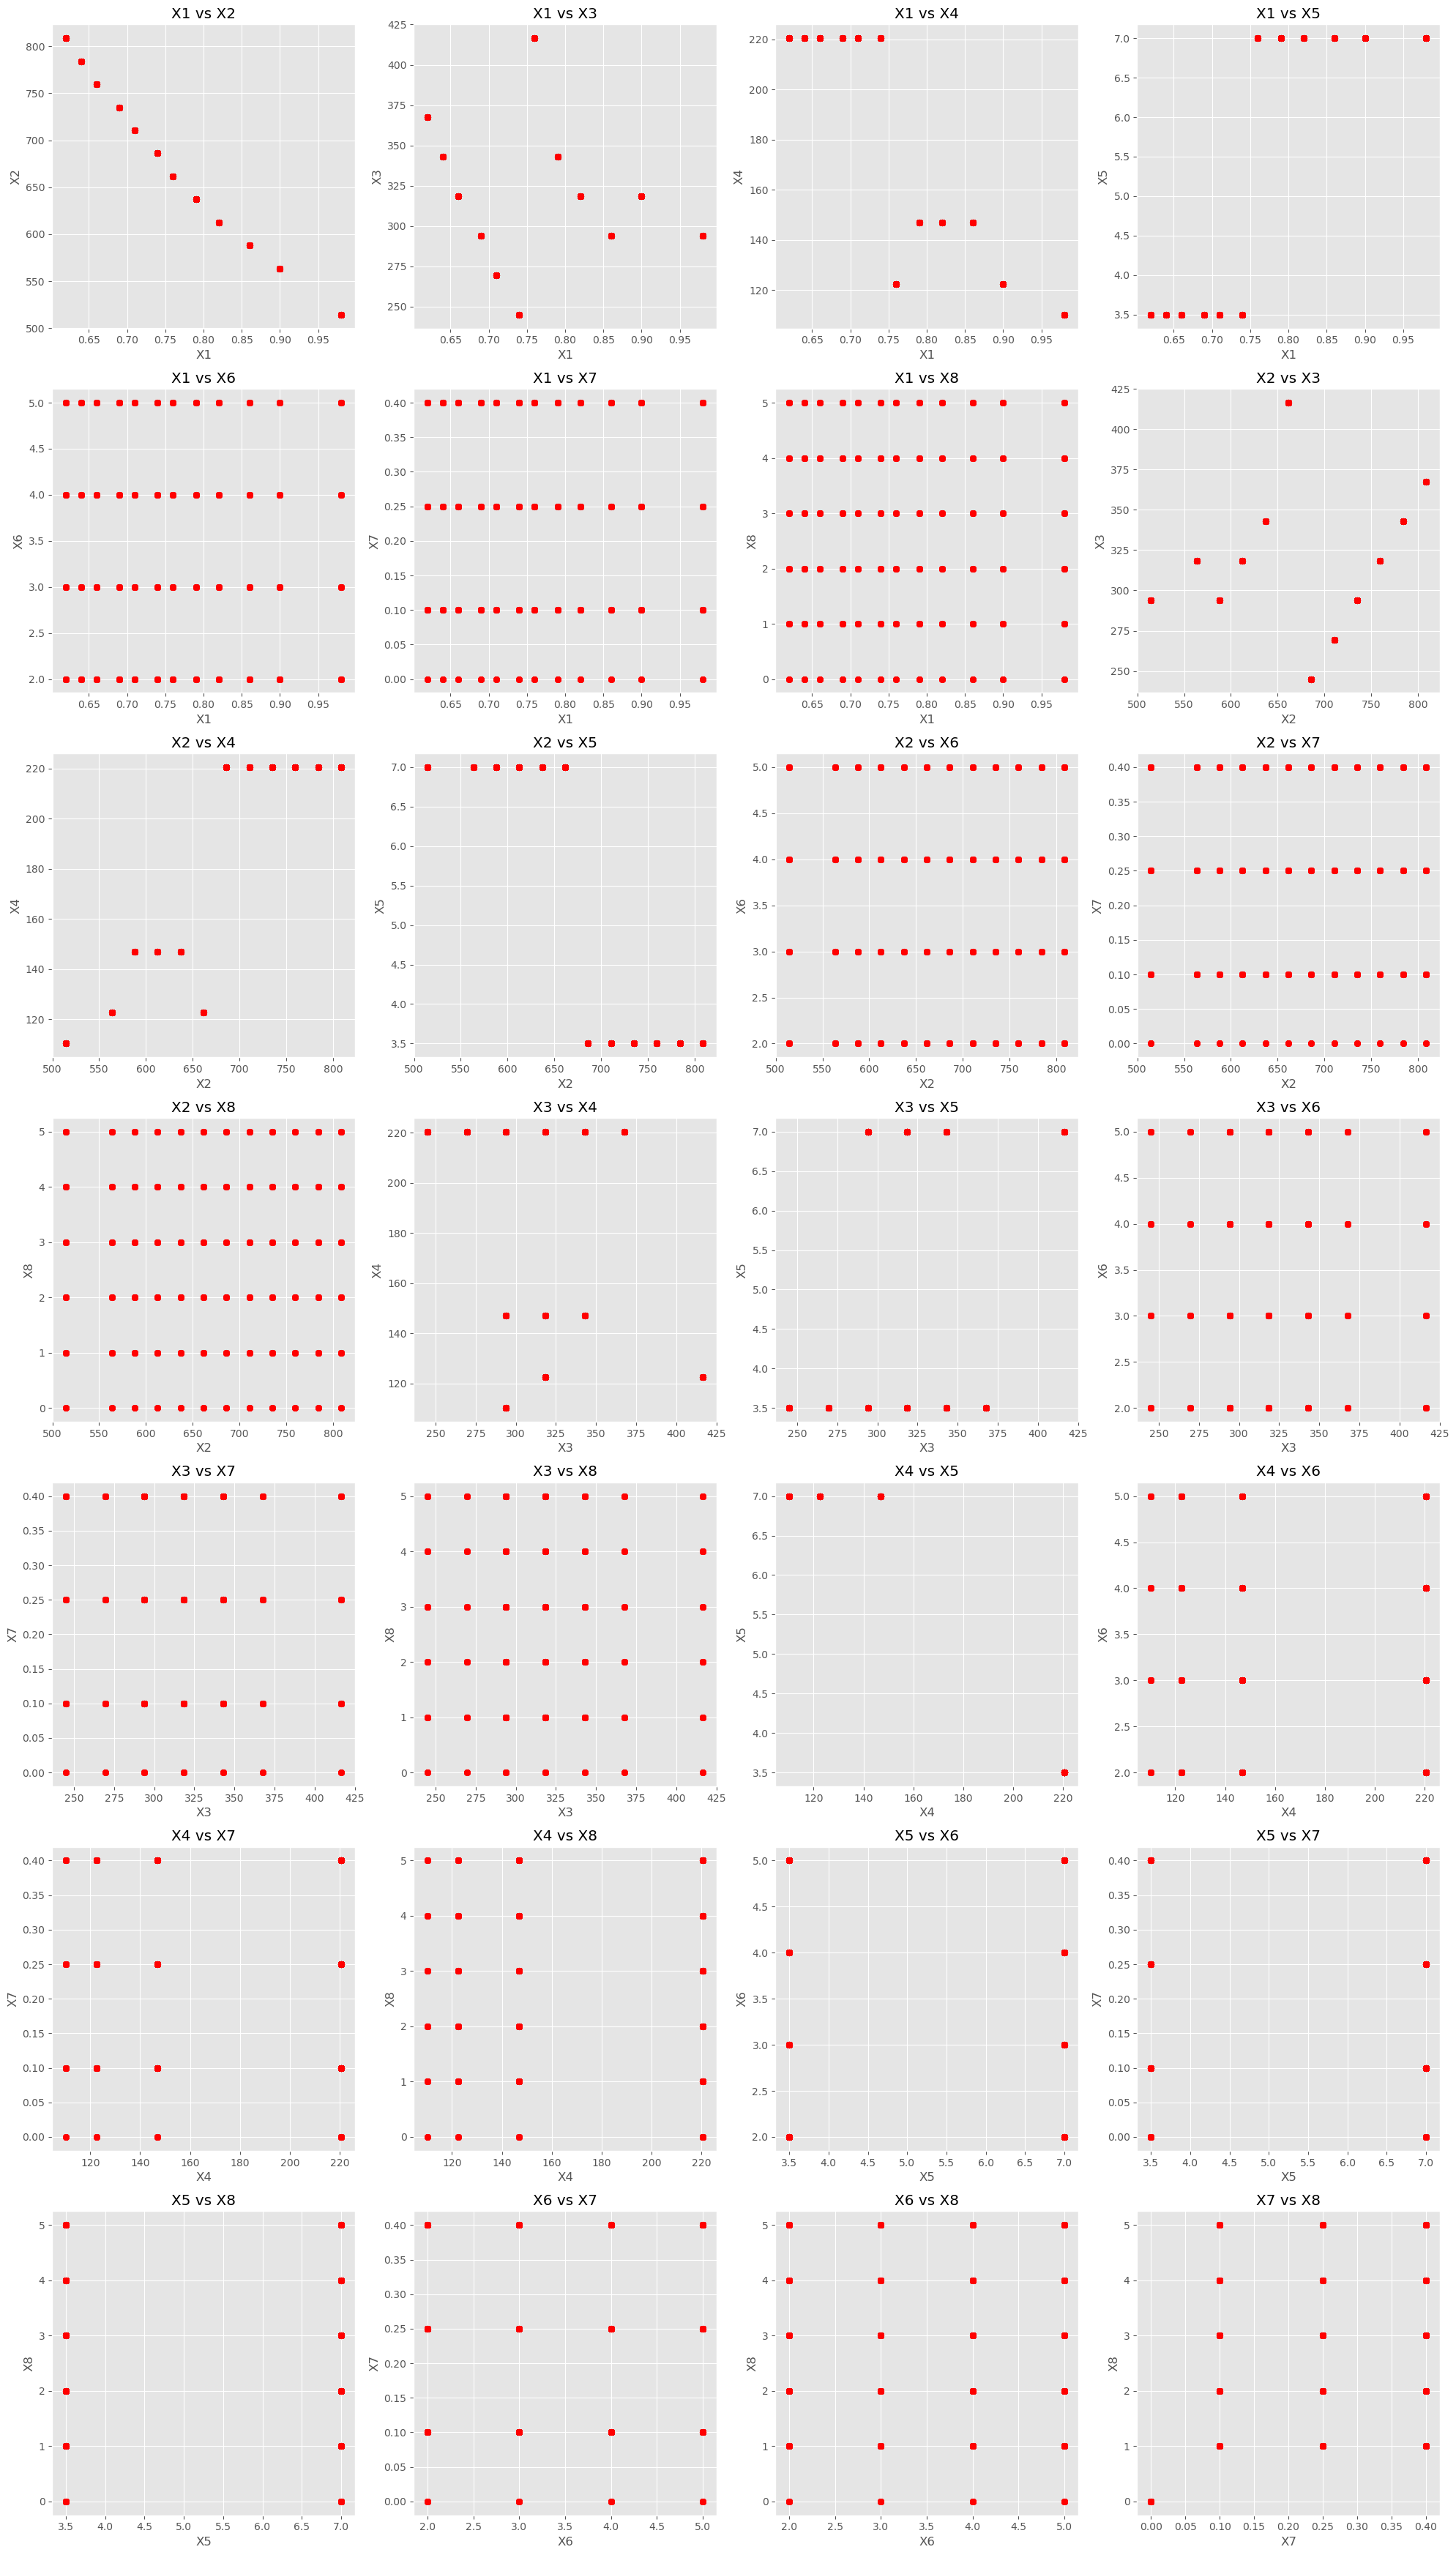

In [215]:
# Crear todas las combinaciones posibles de pares de variables
combinations = list(itertools.combinations(columns, 2))

num_cols=4
# Calcular el número de filas necesario para acomodar todas las combinaciones
num_combinations = len(combinations)
num_rows = num_combinations // num_cols + (num_combinations % num_cols > 0)

# Crear una cuadrícula de subtramas con un número suficiente de filas para todas las combinaciones
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))  # Ajustar el tamaño de figura según sea necesario

# Visualizar gráficos de dispersión para todas las combinaciones
for j, (var1, var2) in enumerate(combinations):
    row = j // num_cols
    col = j % num_cols
    axs[row, col].scatter(dataset_energy[var1], 
                          dataset_energy[var2], 
                          c='red')
    axs[row, col].set_title("{} vs {}".format(var1, var2))
    axs[row, col].set_xlabel(var1)
    axs[row, col].set_ylabel(var2)

# Ajustar el diseño para que no haya superposición
plt.tight_layout()

# Mostrar la figura
plt.show()

Se puede observar una cierta relación inversamente proporcional entre X1 Y X2  para otras variables no se opserva relaciones entre ellas.


División de los datos en entrenamiento (80%) y test (20%):

In [216]:
dataset_train_energy, dataset_test_energy = train_test_split(dataset_energy,
                            test_size=0.2, random_state=SEED_VALUE,
                                    )
dataset_test_energy.loc[:,columns].head()

,X1,X2,X3,X4,X5,X6,X7,X8
285,0.62,808.5,367.5,220.5,3.5,3,0.10,5
101,0.90,563.5,318.5,122.5,7.0,3,0.10,2
581,0.90,563.5,318.5,122.5,7.0,3,0.40,2
352,0.79,637.0,343.0,147.0,7.0,2,0.25,2
726,0.90,563.5,318.5,122.5,7.0,4,0.40,5


Este paso no es necesario

In [217]:
#imp = SimpleImputer(missing_values=np.nan, fill_value='mean')
#imp = imp.fit(dataset_train_energy)  # La media la calculamos SÓLO a partir del conjunto de train

# Los valores van a ser los mismos que antes, pues no tenemos datos faltantes
#dataset_train_prep_energy = imp.transform(dataset_train_energy)
#dataset_test_prep_energy = imp.transform(dataset_test_energy)

#dataset_test_prep_energy

In [218]:

#dataset_train_energy = pd.DataFrame(dataset_train_prep_energy,
#                             columns=dataset_train_energy.columns,
#                             index=dataset_train_energy.index)
#dataset_test_energy = pd.DataFrame(dataset_test_prep_energy,
#                            columns=dataset_test_energy.columns,
#                            index=dataset_test_energy.index)

#dataset_test_energy.loc[:,columns]

**Estandarización de los datos**

Esto hay que hacerlo **ANTES** de dividir en conjuntos de entrenamiento y test. Además, como es un problema de **regresion**, estandarizaremos la variable dependientetambien .


In [219]:

scaler = StandardScaler()

scaler.fit(dataset_train_energy)

dataset_train_scaled_energy = scaler.transform(dataset_train_energy)

dataset_test_scaled_energy = scaler.transform(dataset_test_energy)

dataset_test_scaled_energy

array([[-1.33525558,  1.52364121,  1.12278518, ..., -0.99633936,
         1.40105783, -1.09538181],
       [ 1.28346607, -1.23517832,  0.00816901, ..., -0.99633936,
        -0.54374136,  0.54110007],
       [ 1.28346607, -1.23517832,  0.00816901, ...,  1.26941014,
        -0.54374136,  1.17051617],
       ...,
       [ 0.90936298, -0.95929637, -0.54913907, ..., -0.99633936,
         0.10452504,  0.16662393],
       [ 0.53525988, -0.68341441,  0.00816901, ...,  1.26941014,
         0.75279143,  0.40992763],
       [ 0.25468256, -0.40753246,  0.56547709, ...,  1.26941014,
         0.10452504,  1.47094335]])

In [222]:

print("mean [X1, X2, X3, X4, X5, X6, X7, X8,Y2]: {}".format(scaler.mean_))
print("std [X1, X2, X3, X4, X5, X6, X7, X8,Y2]: {}".format(scaler.scale_))


mean [X1, X2, X3, X4, X5, X6, X7, X8,Y2]: [7.62768730e-01 6.73191368e+02 3.18140879e+02 1.77525244e+02
 5.19869707e+00 3.47394137e+00 2.31921824e-01 2.83876221e+00
 2.43248697e+01]
std [X1, X2, X3, X4, X5, X6, X7, X8,Y2]: [ 0.1069224  88.80609907 43.96132191 45.46444155  1.74924784  1.11918644
  0.13240652  1.54257571  9.45320583]


In [223]:
dataset_train_scaled_energy = pd.DataFrame(dataset_train_scaled_energy,
                             columns=dataset_train_energy.columns,
                             index=dataset_train_energy.index)
dataset_test_scaled_energy = pd.DataFrame(dataset_test_scaled_energy,
                            columns=dataset_test_energy.columns,
                            index=dataset_test_energy.index)


dataset_test_scaled_energy.loc[:,columns].head()

,X1,X2,X3,X4,X5,X6,X7,X8
285,-1.335256,1.523641,1.122785,0.945239,-0.971101,-0.423470,-0.996339,1.401058
101,1.283466,-1.235178,0.008169,-1.210292,1.029759,-0.423470,-0.996339,-0.543741
581,1.283466,-1.235178,0.008169,-1.210292,1.029759,-0.423470,1.269410,-0.543741
352,0.254683,-0.407532,0.565477,-0.671409,1.029759,-1.316976,0.136535,-0.543741
726,1.283466,-1.235178,0.008169,-1.210292,1.029759,0.470037,1.269410,1.401058


**SEPARAMOS LAS VARIABLES**

In [224]:
dataset_train_X_energy = dataset_train_scaled_energy.loc[:, NAME_ENERGY[:-1]].astype(float)
dataset_train_Y_energy = dataset_train_scaled_energy.loc[:, NAME_ENERGY[-1]]
dataset_train_X_energy.head()

,X1,X2,X3,X4,X5,X6,X7,X8
663,-0.961152,0.971877,0.008169,0.945239,-0.971101,1.363543,1.269410,0.104525
712,-1.148204,1.247759,0.565477,0.945239,-0.971101,-1.316976,1.269410,0.752791
161,0.254683,-0.407532,0.565477,-0.671409,1.029759,-0.423470,-0.996339,0.104525
509,-0.493524,0.420113,-1.106447,0.945239,-0.971101,-0.423470,0.136535,1.401058
305,0.254683,-0.407532,0.565477,-0.671409,1.029759,-0.423470,0.136535,-1.192008


In [225]:
dataset_test_X_energy = dataset_test_scaled_energy.loc[:, NAME_ENERGY[:-1]].astype(float)
dataset_test_Y_energy = dataset_test_scaled_energy.loc[:, NAME_ENERGY[-1]]

dataset_test_Y_energy.head()

285   -1.095382
101    0.541100
581    1.170516
352    2.066509
726    1.530183
Name: Y2\t\t, dtype: float64

In [228]:
#Expected n_neighbors <= n_samples,  but n_samples = 491, n_neighbors = 492
# Expected n_neighbors <= n_samples,  n_samples = 477
# Si solo necesitas el número de muestras
n_samples = dataset_train_X_energy.shape[0]

# ('Numero de muestras:', 614) auque pone este valor al usar  GridSearchCV me indica que son 491
print("Numero de muestras:", n_samples)

hyperparameters = {
    'min_samples_split': range(2, n_samples, 1)}
  


Numero de muestras: 614


In [229]:
dataset_train_X_energy.index.equals(dataset_train_Y_energy.index)

True

In [230]:
arbol = DecisionTreeRegressor()
modelCV_energy = GridSearchCV(arbol,
                       hyperparameters,
                       cv=5,
                       scoring="neg_mean_squared_error",
                       return_train_score=True)

# Por como funciona KNN, no haría falta establecer una semilla. Pero lo ponemos igualmente
np.random.seed(SEED_VALUE)

# En KNN no hay aprendizaje en sí, pero hay que ejecutar este comando para poder hacer inferencias
modelCV_energy.fit(dataset_train_X_energy, dataset_train_Y_energy)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'min_samples_split': range(2, 614)},
             return_train_score=True, scoring='neg_mean_squared_error')

In [231]:
cv_results_energy = pd.DataFrame(modelCV_energy.cv_results_)
cv_results_energy.loc[:, [ 'param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]
cv_results_energy['destandardized_mean_test_score'] = (-1) * cv_results_energy['mean_test_score'] * (scaler.scale_[8]**2)
cv_results_energy['destandardized_std_test_score'] = cv_results_energy['std_test_score'] * (scaler.scale_[8]**2)

In [232]:
cv_results_best = cv_results_energy[cv_results_energy['rank_test_score'] == 1]
colums_selected= [ 'param_min_samples_split', 'mean_test_score', 'std_test_score'
                        ,'destandardized_mean_test_score','destandardized_std_test_score','rank_test_score']
cv_results_best.loc[:, colums_selected]

,param_min_samples_split,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
13,15,-0.038047,0.007703,3.400035,0.68836,1


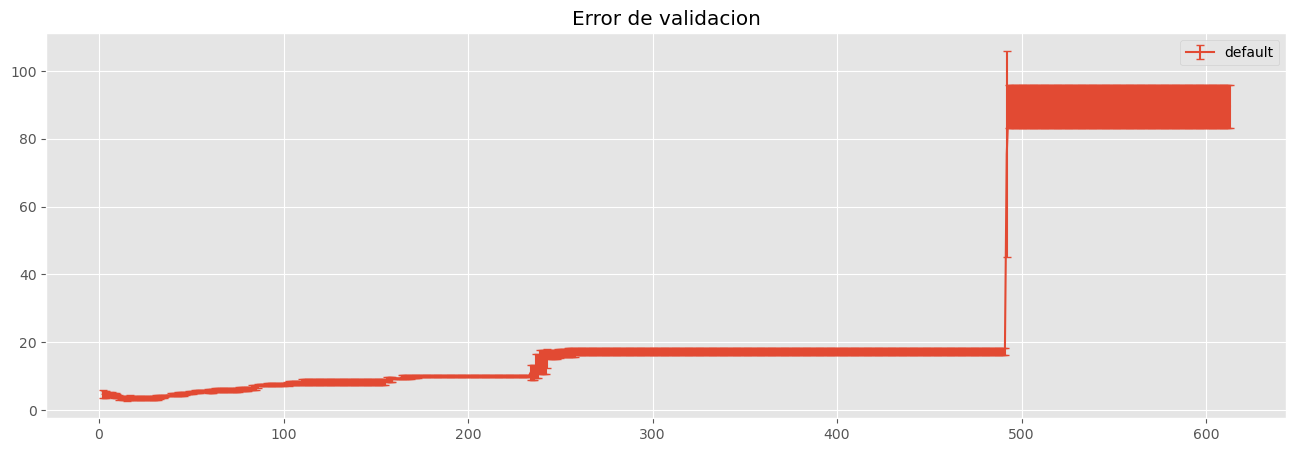

In [233]:
# separamos los pesos basados en cada 
cv_results_uniform = cv_results

plt.figure(figsize=(16, 5))  # Puedes cambiar estos valores según tus necesidades
# eje x xantidad de vecinos y en el y cuanto es el errror
plt.title("Error de validacion")
plt.errorbar(cv_results_energy['param_min_samples_split'],cv_results_energy['destandardized_mean_test_score'],
             cv_results_energy['destandardized_std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

In [234]:
cv_results_best = cv_results_energy[cv_results_energy['rank_test_score'] == 1]
cv_results_best.loc[:, colums_selected]

,param_min_samples_split,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
13,15,-0.038047,0.007703,3.400035,0.68836,1


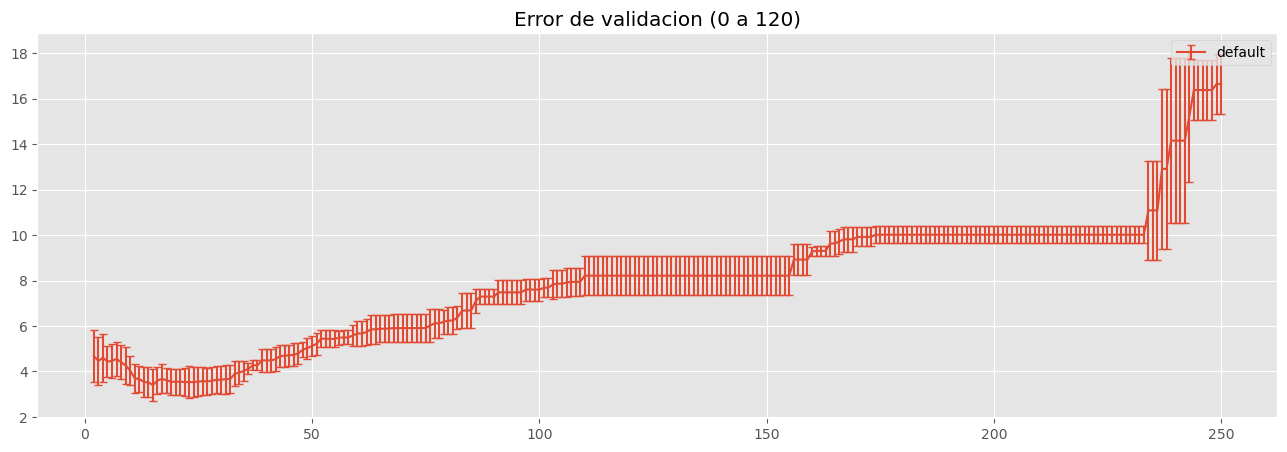

In [236]:
# Primera gráfica: De 0 a 110
plt.figure(figsize=(16, 5))
plt.title("Error de validacion (0 a 120)")
subset = cv_results_energy[cv_results_energy['param_min_samples_split'] <= 250]
plt.errorbar(subset['param_min_samples_split'],subset['destandardized_mean_test_score'],
             subset['destandardized_std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

In [242]:
cv_results_best = cv_results_energy
cv_results_best.loc[:,colums_selected].sort_values(by='rank_test_score').head()

,param_min_samples_split,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
13,15,-0.038047,0.007703,3.400035,0.688360,1
12,14,-0.039367,0.007374,3.517948,0.658958,2
22,24,-0.039528,0.007522,3.532346,0.672223,3
21,23,-0.039542,0.007721,3.533609,0.689998,4
20,22,-0.039548,0.006708,3.534107,0.599468,5


In [249]:
cv_results_best = cv_results_energy[cv_results_energy['rank_test_score'] == 1]
cv_results_best.loc[:, colums_selected]
best_value=cv_results_energy.loc[:, columna_show]
best_value_ind_energy=cv_results_best.index[-1]
print(best_value_ind_energy)

13


In [257]:
# Aplicar la regla de una desviación estándar
best_model = cv_results_energy[cv_results_energy['rank_test_score'] == 1].sort_values(by='param_min_samples_split').iloc[0]
mejor_score = best_model['destandardized_mean_test_score']
mejor_std = best_model['destandardized_std_test_score']

threshold_energy=mejor_score+mejor_std
print(threshold_energy)
cv_results_aux = cv_results_energy[
     cv_results_energy['destandardized_mean_test_score']<=threshold_energy
].sort_values(by='param_min_samples_split', ascending=False)

cv_results_aux = cv_results_aux.loc[:, colums_selected]

cv_results_aux = cv_results_aux.sort_values(by='param_min_samples_split')
cv_results_aux


4.088394538421466


,param_min_samples_split,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
8,10,-0.045226,0.007286,4.041511,0.651140,26
9,11,-0.041368,0.007139,3.696796,0.637991,22
10,12,-0.041079,0.006434,3.670935,0.574995,20
11,13,-0.039614,0.007391,3.540002,0.660456,6
12,14,-0.039367,0.007374,3.517948,0.658958,2
13,15,-0.038047,0.007703,3.400035,0.688360,1
14,16,-0.040301,0.006583,3.601390,0.588233,14
15,17,-0.041154,0.007188,3.677685,0.642317,21
16,18,-0.040382,0.006238,3.608691,0.557408,15
17,19,-0.039707,0.006350,3.548382,0.567428,8


In [261]:
valor_ind_cruzado_energy=cv_results_aux.index[-1]#get_val_cross_validater(cv_results_aux
                         #                 ,best_value_ind_energy)
print(valor_ind_cruzado_energy)

33


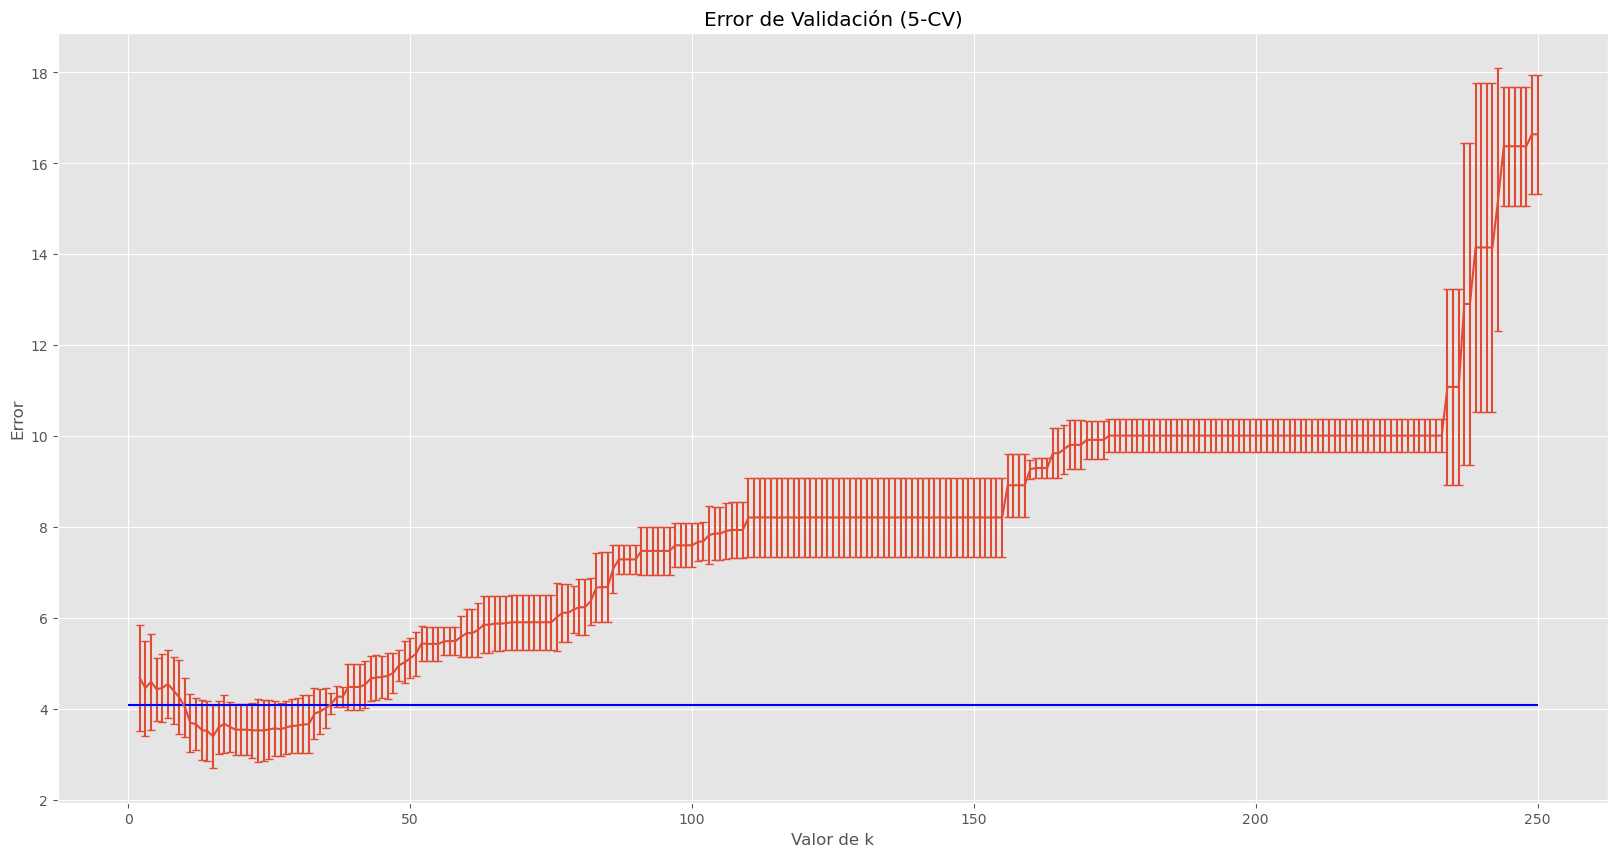

In [262]:


fig, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de k")
ax.set_ylabel("Error")
ubset = cv_results_energy[cv_results_energy['param_min_samples_split'] <= 250]
plt.errorbar(subset['param_min_samples_split'],subset['destandardized_mean_test_score'],
             subset['destandardized_std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
ax.hlines(y=threshold_energy, xmin=0, xmax=250, colors='blue')



En este caso se el valor que se obtiene como el mejor y el que da el la regla de una desviación estándar seria la misma cantidad de neighbors


In [263]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y_energy) + [0]*len(dataset_test_Y_energy)
ps = PredefinedSplit(test_fold=split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_energy, dataset_test_X_energy])
dataset_all_Y = pd.concat([dataset_train_Y_energy, dataset_test_Y_energy])

arbol = DecisionTreeRegressor()
modelCV_test_energy = GridSearchCV(arbol,
                       hyperparameters,
                       cv=ps,
                       scoring='neg_mean_squared_error',
                       return_train_score=True)

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer semilla. Pero lo ponemos igualmente
modelCV_test_energy.fit(dataset_all_X_scaled, dataset_all_Y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeRegressor(),
             param_grid={'min_samples_split': range(2, 614)},
             return_train_score=True, scoring='neg_mean_squared_error')

In [264]:
test_results_energy = pd.DataFrame(modelCV_test_energy.cv_results_)
test_results_energy['destandardized_mean_test_score'] = (-1) * test_results_energy['mean_test_score'] * (scaler.scale_[8]**2)
test_results_energy['destandardized_std_test_score'] = test_results_energy['std_test_score'] * (scaler.scale_[8]**2)
test_results_energy.loc[:, colums_selected]

,param_min_samples_split,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
0,2,-0.073576,0.0,6.575013,0.0,99
1,3,-0.060104,0.0,5.371108,0.0,71
2,4,-0.056486,0.0,5.047736,0.0,50
3,5,-0.057046,0.0,5.097793,0.0,52
4,6,-0.056695,0.0,5.066433,0.0,51
...,...,...,...,...,...,...
607,609,-0.232756,0.0,20.799770,0.0,419
608,610,-0.232756,0.0,20.799770,0.0,419
609,611,-0.232756,0.0,20.799770,0.0,419
610,612,-0.232756,0.0,20.799770,0.0,419


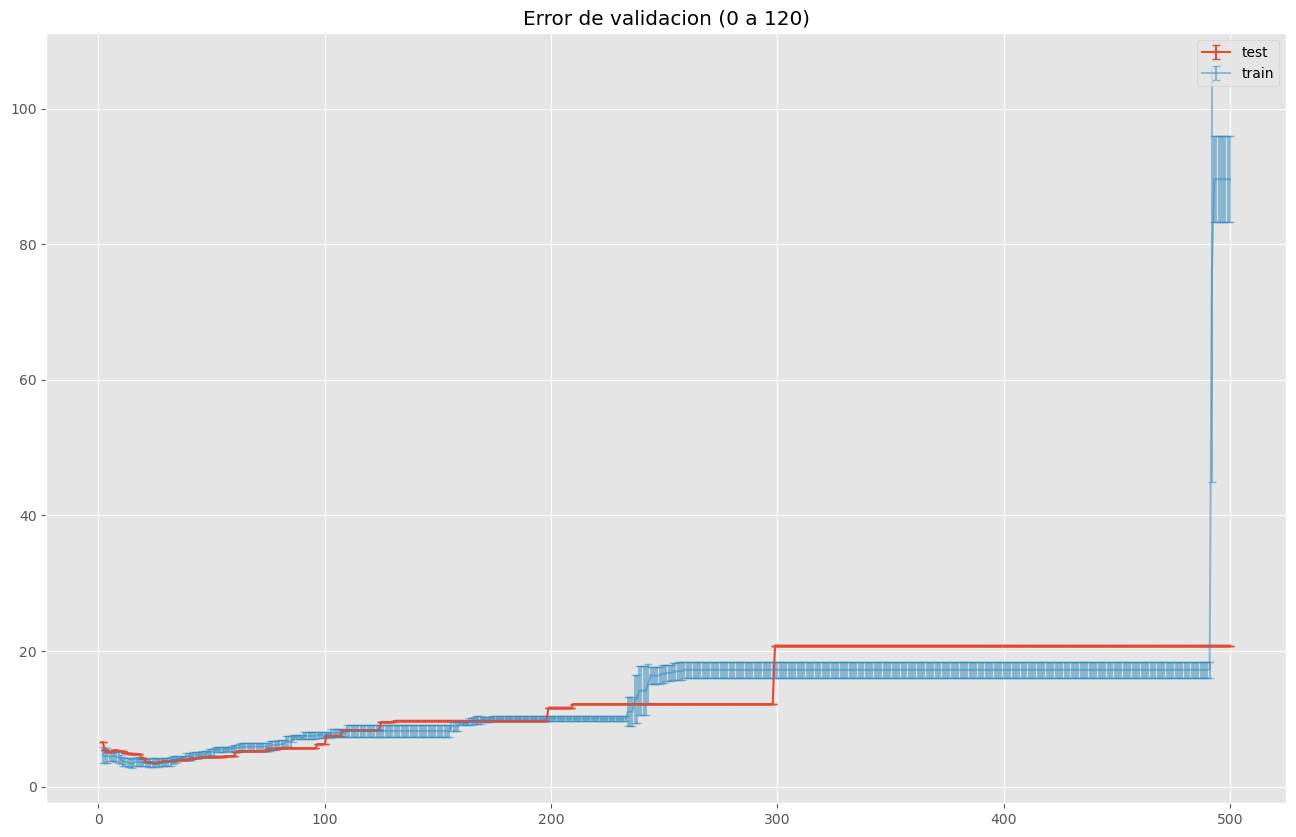

In [268]:
plt.figure(figsize=(16, 10))
plt.title("Error de validacion (0 a 120)")
subset = cv_results_energy[cv_results_energy['param_min_samples_split'] <= 500]
subset_test= test_results_energy[test_results_energy['param_min_samples_split']<= 500]
plt.errorbar(subset_test['param_min_samples_split'],subset_test['destandardized_mean_test_score'],
             subset_test['destandardized_std_test_score'], label='test', capsize=3)  # 1 - [] para imprimir el error

plt.errorbar(subset['param_min_samples_split'],subset['destandardized_mean_test_score'],
             subset['destandardized_std_test_score'], label='train', capsize=3,alpha=0.5)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

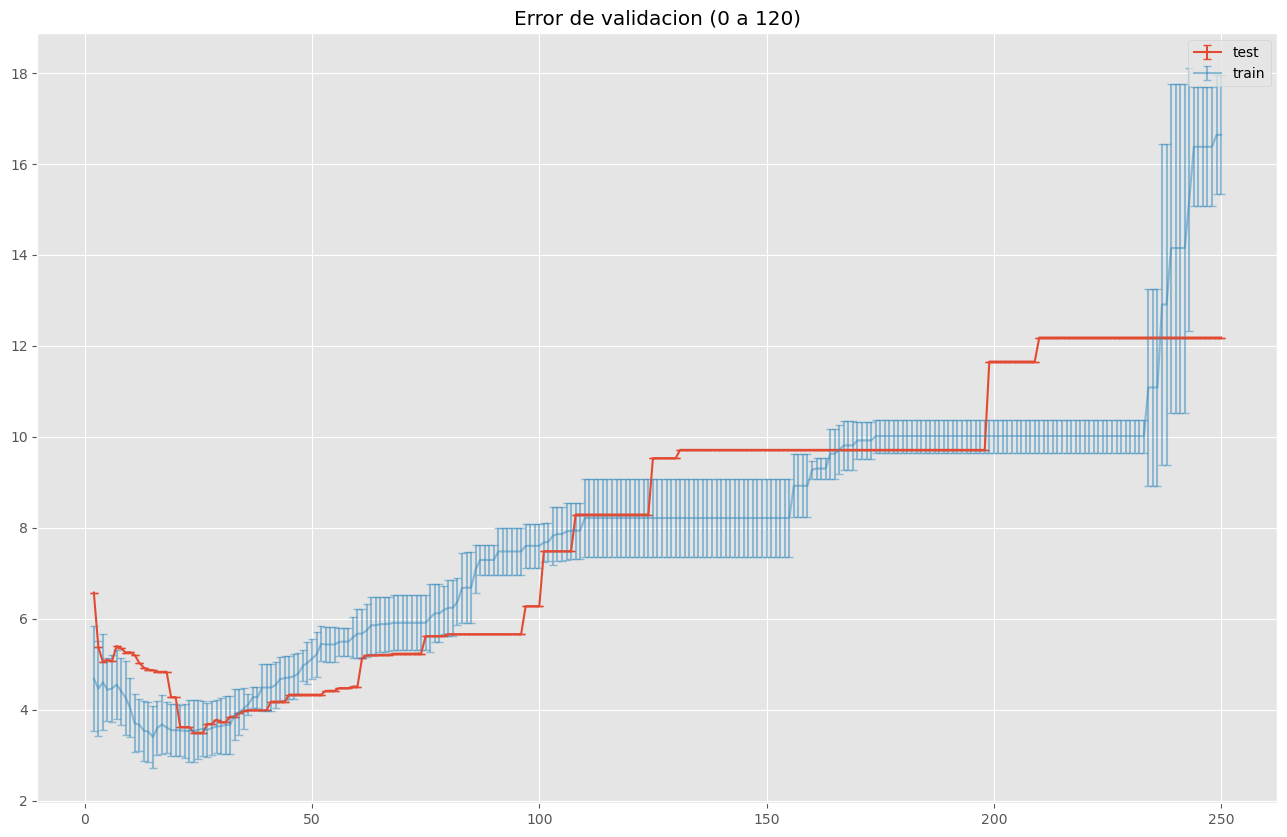

In [269]:
plt.figure(figsize=(16, 10))
plt.title("Error de validacion (0 a 120)")
subset = cv_results_energy[cv_results_energy['param_min_samples_split'] <= 250]
subset_test= test_results_energy[test_results_energy['param_min_samples_split']<= 250]
plt.errorbar(subset_test['param_min_samples_split'],subset_test['destandardized_mean_test_score'],
             subset_test['destandardized_std_test_score'], label='test', capsize=3)  # 1 - [] para imprimir el error

plt.errorbar(subset['param_min_samples_split'],subset['destandardized_mean_test_score'],
             subset['destandardized_std_test_score'], label='train', capsize=3,alpha=0.5)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

In [270]:
test_results_energy.loc[:, colums_selected].sort_values(by='destandardized_mean_test_score').head()

,param_min_samples_split,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
22,24,-0.039077,0.0,3.492052,0.0,1
24,26,-0.039077,0.0,3.492052,0.0,1
23,25,-0.039077,0.0,3.492052,0.0,3
19,21,-0.040491,0.0,3.618426,0.0,4
21,23,-0.040495,0.0,3.618776,0.0,5


In [271]:
test_results_energy.loc[best_value_ind_energy:best_value_ind_energy, colums_selected].sort_values(by='destandardized_mean_test_score').head()

,param_min_samples_split,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
13,15,-0.054498,0.0,4.87007,0.0,46


In [272]:
test_results_energy.loc[valor_ind_cruzado_energy:valor_ind_cruzado_energy, colums_selected].sort_values(by='destandardized_mean_test_score').head()

,param_min_samples_split,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
33,35,-0.044436,0.0,3.970903,0.0,15


En este caso el valor que selencionamos bastante diferencia con el modelo que mejores valores obtenido en el test 